Device: cuda
Total images: 5856
Overall (NORMAL, PNEUMONIA): (1583, 4273)
Split sizes -> Train: 4099 Val: 878 Test: 879
Train (NORMAL,PNEUMONIA): (1108, 2991)
Val   (NORMAL,PNEUMONIA): (237, 641)
Test  (NORMAL,PNEUMONIA): (238, 641)
Showing 10 sample TRAIN images (true labels)...


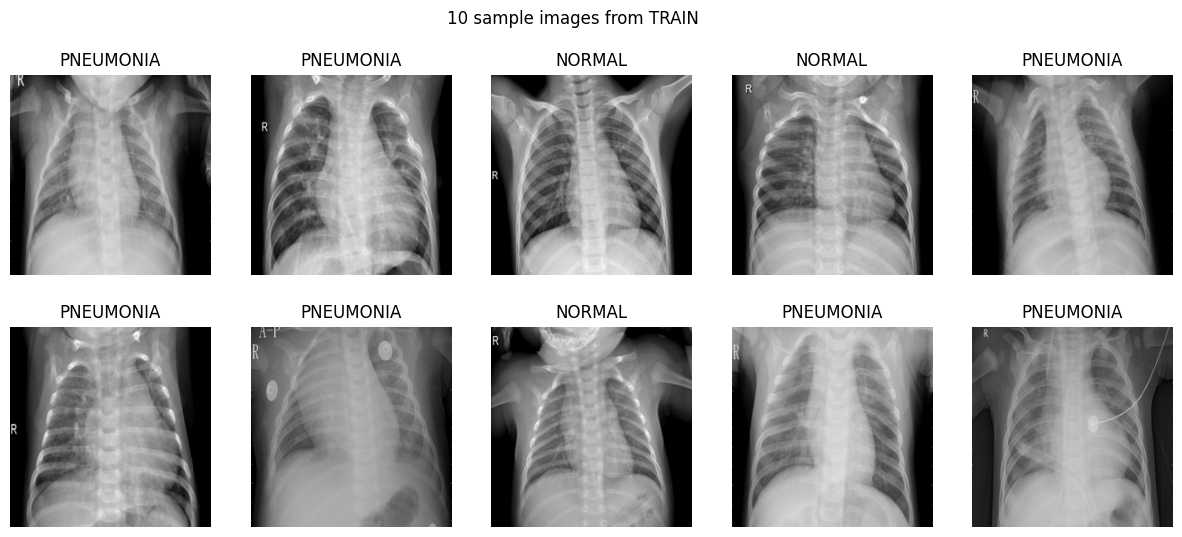

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 238MB/s]


Using model: vit_b_16


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 01/12 | Train loss: 0.4924 (eval_loss: 0.2632) AUC: 0.7592 | Val loss: 0.2566 AUC: 0.9649 Acc: 0.8998 F1: 0.9285
Saved best-by-accuracy model -> best_vit_b_16_by_acc_state_dict.pth
Epoch 02/12 | Train loss: 0.3662 (eval_loss: 0.2106) AUC: 0.8569 | Val loss: 0.2097 AUC: 0.9699 Acc: 0.9237 F1: 0.9470
Saved best-by-accuracy model -> best_vit_b_16_by_acc_state_dict.pth
Epoch 03/12 | Train loss: 0.3090 (eval_loss: 0.2441) AUC: 0.8896 | Val loss: 0.2412 AUC: 0.9765 Acc: 0.9237 F1: 0.9490
Epoch 04/12 | Train loss: 0.2891 (eval_loss: 0.1909) AUC: 0.9001 | Val loss: 0.1889 AUC: 0.9812 Acc: 0.9271 F1: 0.9516
Saved best-by-accuracy model -> best_vit_b_16_by_acc_state_dict.pth
Epoch 05/12 | Train loss: 0.2685 (eval_loss: 0.1405) AUC: 0.9212 | Val loss: 0.1455 AUC: 0.9851 Acc: 0.9556 F1: 0.9698
Saved best-by-accuracy model -> best_vit_b_16_by_acc_state_dict.pth
Epoch 06/12 | Train loss: 0.2838 (eval_loss: 0.1469) AUC: 0.8899 | Val loss: 0.1519 AUC: 0.9840 Acc: 0.9465 F1: 0.9627
Epoch 07/12 | 

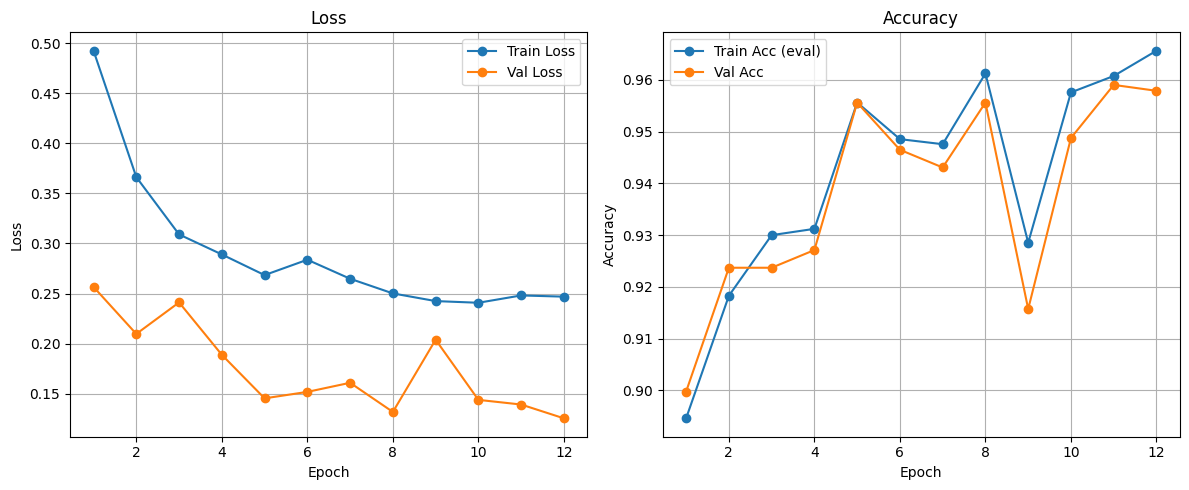

Loading best checkpoint for evaluation...

=== VALIDATION Classification Report ===
              precision    recall  f1-score   support

      NORMAL       0.92      0.93      0.92       237
   PNEUMONIA       0.97      0.97      0.97       641

    accuracy                           0.96       878
   macro avg       0.95      0.95      0.95       878
weighted avg       0.96      0.96      0.96       878

Confusion Matrix (val):
 [[221  16]
 [ 20 621]]

=== TEST Classification Report ===
              precision    recall  f1-score   support

      NORMAL       0.89      0.91      0.90       238
   PNEUMONIA       0.97      0.96      0.96       641

    accuracy                           0.94       879
   macro avg       0.93      0.93      0.93       879
weighted avg       0.94      0.94      0.94       879

Confusion Matrix (test):
 [[216  22]
 [ 27 614]]


/tmp/ipykernel_20/1529808353.py:412: UserWarning: The figure layout has changed to tight
  plt.ylabel('True'); plt.xlabel('Predicted'); plt.tight_layout()


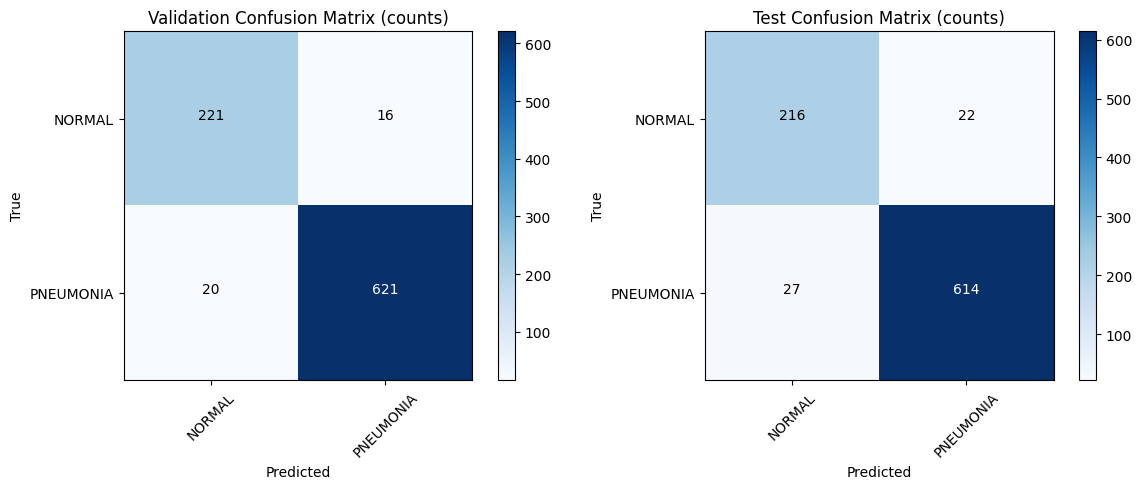

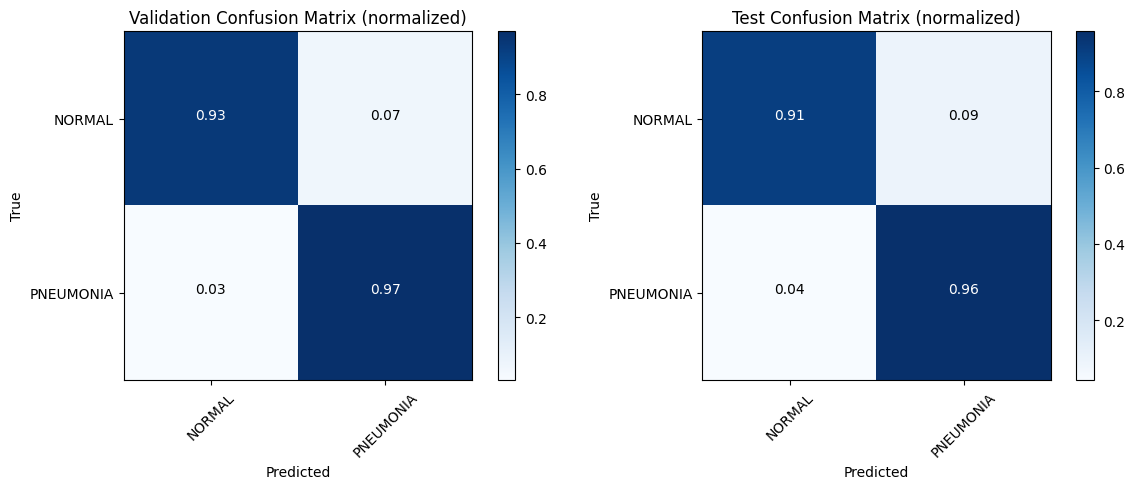

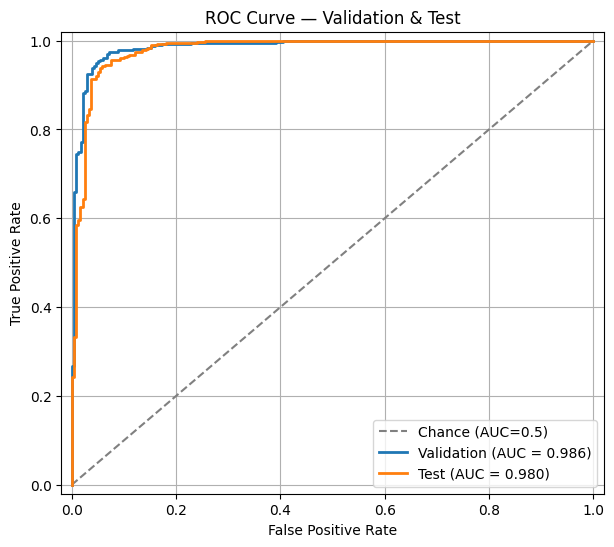

Validation AUC: 0.9857
Test AUC: 0.9795
Done.


In [1]:
# pneumonia_vit_pipeline.py
import os, glob, random, warnings
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_auc_score, accuracy_score, precision_score,
                             recall_score, f1_score, confusion_matrix,
                             classification_report, roc_curve, auc)

# ---------------- Config ----------------
BASE_DIR = "/kaggle/input/chest-xray-pneumonia/chest_xray"  # dataset root
SEED = 42
IMG_SIZE = 224            # ViT-B-16 usually OK with 224; can change to 384 for some variants
BATCH_SIZE = 16
NUM_EPOCHS = 12           # start smaller for ViT (adjust as needed)
LR = 1e-4
WEIGHT_DECAY = 1e-5
MODEL_NAME = "vit_b_16"   # options: "vit_b_16", "vit_l_16" (if available in torchvision)
CHECKPOINT = f"best_{MODEL_NAME}_by_acc_state_dict.pth"
NUM_WORKERS = 2
USE_PIN_MEMORY = True

# MixUp / CutMix
MIXUP_PROB = 0.5
CUTMIX_PROB = 0.5
MIXUP_ALPHA = 0.4
CUTMIX_ALPHA = 1.0

# reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

# ---------------- Transforms ----------------
class GrayToRGB(object):
    def __call__(self, img):
        if img.mode == "L":
            return img.convert("RGB")
        return img

train_transform = transforms.Compose([
    GrayToRGB(),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.85, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(12),
    transforms.ColorJitter(brightness=0.08, contrast=0.08),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225])
])

eval_transform = transforms.Compose([
    GrayToRGB(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225])
])

# ---------------- Collect image paths and labels ----------------
train_paths = glob.glob(os.path.join(BASE_DIR, "train", "*", "*"))
val_paths   = glob.glob(os.path.join(BASE_DIR, "val", "*", "*"))
test_paths  = glob.glob(os.path.join(BASE_DIR, "test", "*", "*"))

all_paths = train_paths + val_paths + test_paths
all_paths = [p for p in all_paths if p.lower().endswith((".png", ".jpg", ".jpeg"))]
if len(all_paths) == 0:
    raise FileNotFoundError(f"No images found under {BASE_DIR}. Run `!ls -R {BASE_DIR}` to inspect.")

def label_from_path(p):
    parent = Path(p).parent.name
    return 1 if parent.lower() == "pneumonia" else 0

all_labels = [label_from_path(p) for p in all_paths]
print("Total images:", len(all_paths))
print("Overall (NORMAL, PNEUMONIA):", (sum(1 for l in all_labels if l==0), sum(1 for l in all_labels if l==1)))

# ---------------- Stratified split 70/15/15 ----------------
train_files, temp_files, train_labels, temp_labels = train_test_split(
    all_paths, all_labels, test_size=0.30, random_state=SEED, stratify=all_labels
)
val_files, test_files, val_labels, test_labels = train_test_split(
    temp_files, temp_labels, test_size=0.5, random_state=SEED, stratify=temp_labels
)

print("Split sizes -> Train:", len(train_files), "Val:", len(val_files), "Test:", len(test_files))
print("Train (NORMAL,PNEUMONIA):", (sum(1 for l in train_labels if l==0), sum(1 for l in train_labels if l==1)))
print("Val   (NORMAL,PNEUMONIA):", (sum(1 for l in val_labels if l==0), sum(1 for l in val_labels if l==1)))
print("Test  (NORMAL,PNEUMONIA):", (sum(1 for l in test_labels if l==0), sum(1 for l in test_labels if l==1)))

# ---------------- Show 10 sample images from TRAIN ----------------
def show_samples(file_list, n=10, seed=SEED):
    n = min(n, len(file_list))
    random.seed(seed)
    sample = random.sample(file_list, n)
    cols = 5
    rows = (n + cols - 1) // cols
    plt.figure(figsize=(cols*3, rows*3))
    for i, p in enumerate(sample):
        img = Image.open(p).convert("RGB").resize((IMG_SIZE, IMG_SIZE))
        label = "PNEUMONIA" if Path(p).parent.name.lower() == "pneumonia" else "NORMAL"
        plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.title(label)
        plt.axis("off")
    plt.suptitle(f"{n} sample images from TRAIN")
    plt.show()

print("Showing 10 sample TRAIN images (true labels)...")
show_samples(train_files, n=10)

# ---------------- Dataset class ----------------
class PneumoniaDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform
    def __len__(self):
        return len(self.file_list)
    def __getitem__(self, idx):
        path = self.file_list[idx]
        parent = Path(path).parent.name
        label = 1 if parent.lower() == "pneumonia" else 0
        img = Image.open(path)
        if self.transform:
            img = self.transform(img)
        return img, label

# ---------------- Dataloaders ----------------
train_ds = PneumoniaDataset(train_files, transform=train_transform)
train_eval_ds = PneumoniaDataset(train_files, transform=eval_transform)
val_ds = PneumoniaDataset(val_files, transform=eval_transform)
test_ds = PneumoniaDataset(test_files, transform=eval_transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=USE_PIN_MEMORY)
train_eval_loader = DataLoader(train_eval_ds, batch_size=BATCH_SIZE, shuffle=False,
                               num_workers=NUM_WORKERS, pin_memory=USE_PIN_MEMORY)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, pin_memory=USE_PIN_MEMORY)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=NUM_WORKERS, pin_memory=USE_PIN_MEMORY)

# ---------------- Model loader for ViT ----------------
def get_vit_model(model_name="vit_b_16", num_classes=2, pretrained=True):
    """
    Try to create a ViT variant using torchvision factories (safe weights API).
    Falls back to a generic model if necessary.
    """
    name = model_name.lower()
    try:
        if name == "vit_b_16":
            weights_cls = getattr(models, "ViT_B_16_Weights", None)
            if weights_cls is not None:
                model = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)
            else:
                model = models.vit_b_16(pretrained=pretrained)
        elif name == "vit_l_16":
            weights_cls = getattr(models, "ViT_L_16_Weights", None)
            if weights_cls is not None:
                model = models.vit_l_16(weights=models.ViT_L_16_Weights.IMAGENET1K_V1)
            else:
                model = models.vit_l_16(pretrained=pretrained)
        else:
            # try passing the exact factory name
            factory = getattr(models, model_name, None)
            if factory is None:
                raise ValueError(f"Unknown ViT variant: {model_name}")
            model = factory(pretrained=pretrained)

        # Replace classifier head safely:
        # torchvision ViT uses model.heads (nn.Sequential) with 'head' Linear or model.heads.head
        hooked = False
        if hasattr(model, "heads"):
            # try common patterns
            if isinstance(model.heads, nn.Sequential):
                # find last Linear inside heads
                for i in range(len(model.heads)-1, -1, -1):
                    if isinstance(model.heads[i], nn.Linear):
                        in_f = model.heads[i].in_features
                        model.heads[i] = nn.Linear(in_f, num_classes)
                        hooked = True
                        break
            elif hasattr(model.heads, "head") and isinstance(model.heads.head, nn.Linear):
                in_f = model.heads.head.in_features
                model.heads.head = nn.Linear(in_f, num_classes)
                hooked = True
        if not hooked and hasattr(model, "head") and isinstance(model.head, nn.Linear):
            in_f = model.head.in_features
            model.head = nn.Linear(in_f, num_classes)
            hooked = True

        if not hooked:
            # fallback: find last Linear in entire model and replace
            linear_names = [n for n, m in model.named_modules() if isinstance(m, nn.Linear)]
            if len(linear_names) > 0:
                last_name = linear_names[-1]
                parent = model
                parts = last_name.split(".")
                for p in parts[:-1]:
                    parent = getattr(parent, p)
                last_attr = parts[-1]
                in_f = getattr(parent, last_attr).in_features
                setattr(parent, last_attr, nn.Linear(in_f, num_classes))
                hooked = True

        if not hooked:
            warnings.warn("Could not reliably replace ViT head. Model created but head may be incorrect.")
        return model

    except Exception as e:
        warnings.warn(f"Failed to create requested ViT model ({e}). Falling back to ResNet-50.")
        # fallback
        m = models.resnet50(pretrained=True)
        in_f = m.fc.in_features
        m.fc = nn.Linear(in_f, num_classes)
        return m

# instantiate model
model = get_vit_model(MODEL_NAME, num_classes=2, pretrained=True).to(DEVICE)
print(f"Using model: {MODEL_NAME}")

# ---------------- Loss / Optimizer / Scheduler ----------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=False)

# ---------------- MixUp & CutMix helpers ----------------
def rand_bbox(size, lam):
    W = size[3]; H = size[2]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)
    cx = np.random.randint(W); cy = np.random.randint(H)
    x1 = np.clip(cx - cut_w // 2, 0, W); y1 = np.clip(cy - cut_h // 2, 0, H)
    x2 = np.clip(cx + cut_w // 2, 0, W); y2 = np.clip(cy + cut_h // 2, 0, H)
    return x1, y1, x2, y2

def mixup_data(x, y, alpha=MIXUP_ALPHA):
    if alpha <= 0: return x, y, y, 1.0
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    return mixed_x, y, y[index], lam

def cutmix_data(x, y, alpha=CUTMIX_ALPHA):
    if alpha <= 0: return x, y, y, 1.0
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    x1 = x.clone(); x2 = x[index, :]
    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
    x1[:, :, bby1:bby2, bbx1:bbx2] = x2[:, :, bby1:bby2, bbx1:bbx2]
    lam_adj = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size(-1) * x.size(-2) + 1e-8))
    return x1, y, y[index], lam_adj

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# ---------------- Training & Evaluation helpers ----------------
def train_one_epoch():
    model.train()
    running_loss = 0.0
    all_labels, all_probs = [], []
    for imgs, labels in train_loader:
        imgs = imgs.to(DEVICE); labels = labels.to(DEVICE)
        if random.random() < MIXUP_PROB:
            if random.random() < CUTMIX_PROB:
                imgs_m, ya, yb, lam = cutmix_data(imgs, labels)
            else:
                imgs_m, ya, yb, lam = mixup_data(imgs, labels)
            outputs = model(imgs_m)
            loss = mixup_criterion(criterion, outputs, ya, yb, lam)
            probs = torch.softmax(outputs, dim=1)[:,1].detach().cpu().numpy()
        else:
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            probs = torch.softmax(outputs, dim=1)[:,1].detach().cpu().numpy()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        all_probs.extend(probs.tolist())
        all_labels.extend(labels.cpu().numpy().tolist())

    avg_loss = running_loss / len(train_ds)
    auc = roc_auc_score(all_labels, all_probs) if len(set(all_labels)) > 1 else float('nan')
    return avg_loss, auc

def evaluate(loader):
    model.eval()
    running_loss = 0.0
    all_labels, all_probs = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(DEVICE); labels = labels.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * imgs.size(0)
            probs = torch.softmax(outputs, dim=1)[:,1].cpu().numpy()
            all_probs.extend(probs.tolist())
            all_labels.extend(labels.cpu().numpy().tolist())
    avg_loss = running_loss / (len(loader.dataset))
    auc = roc_auc_score(all_labels, all_probs) if len(set(all_labels)) > 1 else float('nan')
    preds = [1 if p >= 0.5 else 0 for p in all_probs]
    acc = accuracy_score(all_labels, preds)
    prec = precision_score(all_labels, preds, zero_division=0)
    rec = recall_score(all_labels, preds, zero_division=0)
    f1 = f1_score(all_labels, preds, zero_division=0)
    return avg_loss, auc, acc, prec, rec, f1, all_probs, all_labels

# ---------------- History tracking ----------------
history_train_loss, history_val_loss = [], []
history_train_acc, history_val_acc = [], []

# ---------------- Train loop (save best by VAL accuracy) ----------------
best_val_acc = -1.0
for epoch in range(1, NUM_EPOCHS+1):
    train_loss, train_auc = train_one_epoch()
    # compute train eval metrics on eval_transform version (no augmentation)
    train_eval_loss, train_eval_auc, train_eval_acc, _, _, _, _, _ = evaluate(train_eval_loader)
    val_loss, val_auc, val_acc, val_prec, val_rec, val_f1, _, _ = evaluate(val_loader)

    history_train_loss.append(train_loss)
    history_val_loss.append(val_loss)
    history_train_acc.append(train_eval_acc)
    history_val_acc.append(val_acc)

    ta = f"{train_auc:.4f}" if not np.isnan(train_auc) else "-"
    va = f"{val_auc:.4f}" if not np.isnan(val_auc) else "-"
    print(f"Epoch {epoch:02d}/{NUM_EPOCHS} | Train loss: {train_loss:.4f} (eval_loss: {train_eval_loss:.4f}) AUC: {ta} | "
          f"Val loss: {val_loss:.4f} AUC: {va} Acc: {val_acc:.4f} F1: {val_f1:.4f}")

    # save state_dict only
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), CHECKPOINT)
        print(f"Saved best-by-accuracy model -> {CHECKPOINT}")

    if not np.isnan(val_auc):
        scheduler.step(val_auc)

# ---------------- Plot Loss & Accuracy curves ----------------
epochs = range(1, len(history_train_loss)+1)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, history_train_loss, label="Train Loss", marker='o')
plt.plot(epochs, history_val_loss, label="Val Loss", marker='o')
plt.title("Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(epochs, history_train_acc, label="Train Acc (eval)", marker='o')
plt.plot(epochs, history_val_acc, label="Val Acc", marker='o')
plt.title("Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.grid(True)
plt.tight_layout(); plt.show()

# ---------------- Load best checkpoint and final reports ----------------
print("Loading best checkpoint for evaluation...")
if os.path.exists(CHECKPOINT):
    sd = torch.load(CHECKPOINT, map_location=DEVICE)
    model.load_state_dict(sd)
else:
    print("No checkpoint found; using current weights.")

# Validation report
_, _, val_acc, _, _, _, val_probs, val_truth = evaluate(val_loader)
val_preds = [1 if p >= 0.5 else 0 for p in val_probs]
print("\n=== VALIDATION Classification Report ===")
print(classification_report(val_truth, val_preds, target_names=["NORMAL","PNEUMONIA"]))
print("Confusion Matrix (val):\n", confusion_matrix(val_truth, val_preds))

# Test report
_, _, test_acc, _, _, _, test_probs, test_truth = evaluate(test_loader)
test_preds = [1 if p >= 0.5 else 0 for p in test_probs]
print("\n=== TEST Classification Report ===")
print(classification_report(test_truth, test_preds, target_names=["NORMAL","PNEUMONIA"]))
print("Confusion Matrix (test):\n", confusion_matrix(test_truth, test_preds))

# ---------------- Plot confusion matrices ----------------
def plot_cm(cm, classes, title, normalize=False):
    if normalize:
        cm_disp = cm.astype('float') / (cm.sum(axis=1, keepdims=True) + 1e-8)
    else:
        cm_disp = cm
    plt.imshow(cm_disp, interpolation='nearest', cmap='Blues')
    plt.title(title); plt.colorbar()
    ticks = np.arange(len(classes))
    plt.xticks(ticks, classes, rotation=45); plt.yticks(ticks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm_disp.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            txt = format(cm_disp[i,j], fmt) if normalize else format(int(cm[i,j]), fmt)
            plt.text(j, i, txt, horizontalalignment="center",
                     color="white" if cm_disp[i,j] > thresh else "black")
    plt.ylabel('True'); plt.xlabel('Predicted'); plt.tight_layout()

val_cm = confusion_matrix(val_truth, val_preds)
test_cm = confusion_matrix(test_truth, test_preds)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plot_cm(val_cm, ["NORMAL","PNEUMONIA"], "Validation Confusion Matrix (counts)", normalize=False)
plt.subplot(1,2,2); plot_cm(test_cm, ["NORMAL","PNEUMONIA"], "Test Confusion Matrix (counts)", normalize=False)
plt.show()

plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plot_cm(val_cm, ["NORMAL","PNEUMONIA"], "Validation Confusion Matrix (normalized)", normalize=True)
plt.subplot(1,2,2); plot_cm(test_cm, ["NORMAL","PNEUMONIA"], "Test Confusion Matrix (normalized)", normalize=True)
plt.show()

# ---------------- ROC curve (val & test) ----------------
def plot_roc(ax, y_true, y_prob, label):
    if len(np.unique(y_true)) < 2:
        print(f"ROC not defined for {label}: only one class present.")
        return None
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, lw=2, label=f"{label} (AUC = {roc_auc:.3f})")
    return roc_auc

val_y = np.array(val_truth); val_p = np.array(val_probs)
test_y = np.array(test_truth); test_p = np.array(test_probs)

plt.figure(figsize=(7,6))
ax = plt.gca()
ax.plot([0,1],[0,1], linestyle='--', color='gray', label='Chance (AUC=0.5)')
val_auc = plot_roc(ax, val_y, val_p, "Validation")
test_auc = plot_roc(ax, test_y, test_p, "Test")
ax.set_xlim([-0.02,1.02]); ax.set_ylim([-0.02,1.02])
ax.set_xlabel("False Positive Rate"); ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curve — Validation & Test"); ax.legend(loc='lower right'); ax.grid(True)
plt.show()

if val_auc is not None: print(f"Validation AUC: {val_auc:.4f}")
if test_auc is not None: print(f"Test AUC: {test_auc:.4f}")

print("Done.")


Device: cuda
Total images: 5856
Overall (NORMAL, PNEUMONIA): (1583, 4273)
Split sizes -> Train: 4099 Val: 878 Test: 879
Train (NORMAL,PNEUMONIA): (1108, 2991)
Val   (NORMAL,PNEUMONIA): (237, 641)
Test  (NORMAL,PNEUMONIA): (238, 641)
Showing 10 sample TRAIN images (true labels)...


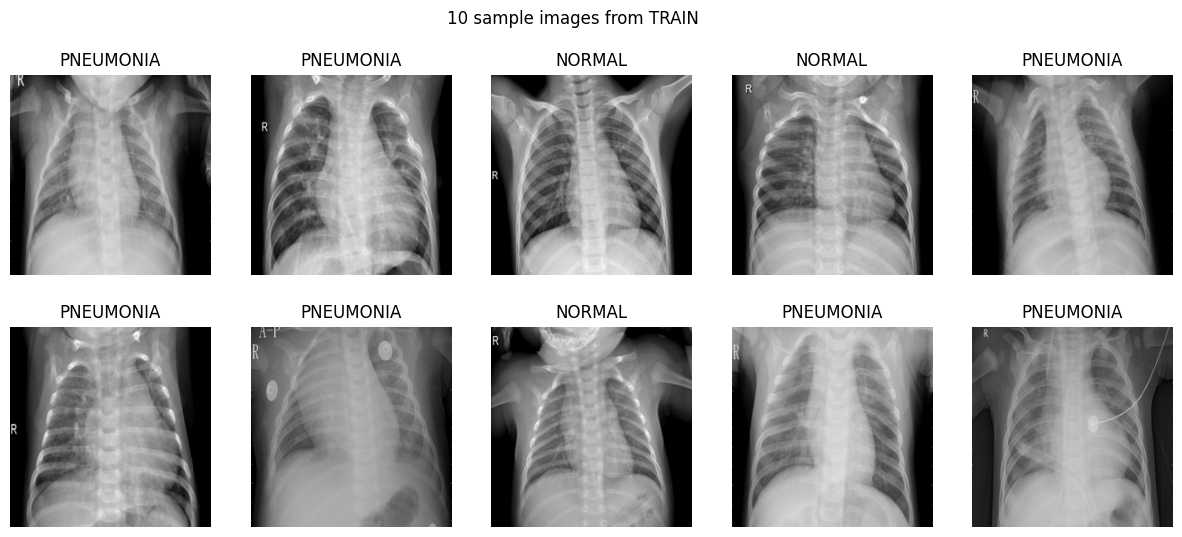

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 161MB/s]


Using EfficientNet-B0


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 01/20 | Train loss: 0.2921 AUC: 0.9086 | Val loss: 0.1336 AUC: 0.9888 Acc: 0.9567 F1: 0.9699
Saved best-by-accuracy model (Val Acc=0.9567) -> best_pneumonia_by_acc_state_dict.pth
Epoch 02/20 | Train loss: 0.2290 AUC: 0.9119 | Val loss: 0.1116 AUC: 0.9937 Acc: 0.9613 F1: 0.9732
Saved best-by-accuracy model (Val Acc=0.9613) -> best_pneumonia_by_acc_state_dict.pth
Epoch 03/20 | Train loss: 0.1996 AUC: 0.9242 | Val loss: 0.1400 AUC: 0.9915 Acc: 0.9408 F1: 0.9581
Epoch 04/20 | Train loss: 0.2049 AUC: 0.9210 | Val loss: 0.1329 AUC: 0.9921 Acc: 0.9453 F1: 0.9617
Epoch 05/20 | Train loss: 0.1789 AUC: 0.9507 | Val loss: 0.0767 AUC: 0.9954 Acc: 0.9727 F1: 0.9812
Saved best-by-accuracy model (Val Acc=0.9727) -> best_pneumonia_by_acc_state_dict.pth
Epoch 06/20 | Train loss: 0.1911 AUC: 0.9107 | Val loss: 0.0806 AUC: 0.9948 Acc: 0.9749 F1: 0.9829
Saved best-by-accuracy model (Val Acc=0.9749) -> best_pneumonia_by_acc_state_dict.pth
Epoch 07/20 | Train loss: 0.1849 AUC: 0.9078 | Val loss: 0.092

In [2]:
# pneumonia_pipeline_final_fixed.py
import os
import glob
import random
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import warnings

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_auc_score, accuracy_score, precision_score,
                             recall_score, f1_score, confusion_matrix,
                             classification_report)

# ---------------- Config ----------------
BASE_DIR = "/kaggle/input/chest-xray-pneumonia/chest_xray"  # Kaggle dataset root
SEED = 42
IMG_SIZE = 224
BATCH_SIZE = 16
NUM_EPOCHS = 20
LR = 1e-4
WEIGHT_DECAY = 1e-5
CHECKPOINT_BY_ACC = "best_pneumonia_by_acc_state_dict.pth"  # will store model.state_dict()
NUM_WORKERS = 2
USE_PIN_MEMORY = True

# MixUp / CutMix params
MIXUP_PROB = 0.5
CUTMIX_PROB = 0.5
MIXUP_ALPHA = 0.4
CUTMIX_ALPHA = 1.0

# reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

# ---------------- Transforms ----------------
class GrayToRGB(object):
    def __call__(self, img):
        if img.mode == "L":
            return img.convert("RGB")
        return img

train_transform = transforms.Compose([
    GrayToRGB(),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.85, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(12),
    transforms.ColorJitter(brightness=0.08, contrast=0.08),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    GrayToRGB(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225])
])

# --------------- Collect all image paths and labels ---------------
train_paths = glob.glob(os.path.join(BASE_DIR, "train", "*", "*"))
val_paths   = glob.glob(os.path.join(BASE_DIR, "val", "*", "*"))
test_paths  = glob.glob(os.path.join(BASE_DIR, "test", "*", "*"))

all_paths = train_paths + val_paths + test_paths
all_paths = [p for p in all_paths if p.lower().endswith((".png", ".jpg", ".jpeg"))]

if len(all_paths) == 0:
    raise FileNotFoundError(f"No images found under {BASE_DIR}. Run `!ls -R {BASE_DIR}` to inspect.")

def label_from_path(p):
    parent = Path(p).parent.name
    return 1 if parent.lower() == "pneumonia" else 0

all_labels = [label_from_path(p) for p in all_paths]

print("Total images:", len(all_paths))
print("Overall (NORMAL, PNEUMONIA):", (sum(1 for l in all_labels if l==0), sum(1 for l in all_labels if l==1)))

# --------------- Stratified split: 70/15/15 ---------------
train_files, temp_files, train_labels, temp_labels = train_test_split(
    all_paths, all_labels, test_size=0.30, random_state=SEED, stratify=all_labels
)
val_files, test_files, val_labels, test_labels = train_test_split(
    temp_files, temp_labels, test_size=0.5, random_state=SEED, stratify=temp_labels
)

print("Split sizes -> Train:", len(train_files), "Val:", len(val_files), "Test:", len(test_files))
print("Train (NORMAL,PNEUMONIA):", (sum(1 for l in train_labels if l==0), sum(1 for l in train_labels if l==1)))
print("Val   (NORMAL,PNEUMONIA):", (sum(1 for l in val_labels if l==0), sum(1 for l in val_labels if l==1)))
print("Test  (NORMAL,PNEUMONIA):", (sum(1 for l in test_labels if l==0), sum(1 for l in test_labels if l==1)))

# --------------- Show 10 sample images from TRAIN before training ---------------
def show_samples(file_list, n=10, seed=SEED):
    n = min(n, len(file_list))
    random.seed(seed)
    sample = random.sample(file_list, n)
    cols = 5
    rows = (n + cols - 1) // cols
    plt.figure(figsize=(cols*3, rows*3))
    for i, p in enumerate(sample):
        img = Image.open(p).convert("RGB").resize((IMG_SIZE, IMG_SIZE))
        label = "PNEUMONIA" if Path(p).parent.name.lower() == "pneumonia" else "NORMAL"
        plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.title(label)
        plt.axis("off")
    plt.suptitle(f"{n} sample images from TRAIN")
    plt.show()

print("Showing 10 sample TRAIN images (true labels)...")
show_samples(train_files, n=10)

# --------------- Dataset class ---------------
class PneumoniaDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform
    def __len__(self):
        return len(self.file_list)
    def __getitem__(self, idx):
        path = self.file_list[idx]
        parent = Path(path).parent.name
        label = 1 if parent.lower() == "pneumonia" else 0
        img = Image.open(path)
        if self.transform:
            img = self.transform(img)
        return img, label

# --------------- Dataloaders ---------------
train_ds = PneumoniaDataset(train_files, transform=train_transform)
val_ds   = PneumoniaDataset(val_files,   transform=val_transform)
test_ds  = PneumoniaDataset(test_files,  transform=val_transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=USE_PIN_MEMORY)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=USE_PIN_MEMORY)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=USE_PIN_MEMORY)

# --------------- Model (EfficientNet-B0 weights API fallback) ---------------
def get_model(num_classes=2):
    try:
        # prefer modern weights API if available
        weights_cls = getattr(models, "EfficientNet_B0_Weights", None)
        if weights_cls is not None:
            model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        else:
            model = models.efficientnet_b0(pretrained=True)
        in_f = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(in_f, num_classes)
        print("Using EfficientNet-B0")
    except Exception as e:
        warnings.warn(f"EfficientNet failed ({e}), falling back to ResNet-50")
        model = models.resnet50(pretrained=True)
        in_f = model.fc.in_features
        model.fc = nn.Linear(in_f, num_classes)
        print("Using ResNet-50")
    return model

model = get_model(num_classes=2).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=False)

# --------------- MixUp & CutMix helpers ---------------
def rand_bbox(size, lam):
    W = size[3]; H = size[2]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)
    cx = np.random.randint(W); cy = np.random.randint(H)
    x1 = np.clip(cx - cut_w // 2, 0, W); y1 = np.clip(cy - cut_h // 2, 0, H)
    x2 = np.clip(cx + cut_w // 2, 0, W); y2 = np.clip(cy + cut_h // 2, 0, H)
    return x1, y1, x2, y2

def mixup_data(x, y, alpha=MIXUP_ALPHA):
    if alpha <= 0: return x, y, y, 1.0
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    return mixed_x, y, y[index], lam

def cutmix_data(x, y, alpha=CUTMIX_ALPHA):
    if alpha <= 0: return x, y, y, 1.0
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    x1 = x.clone(); x2 = x[index, :]
    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
    x1[:, :, bby1:bby2, bbx1:bbx2] = x2[:, :, bby1:bby2, bbx1:bbx2]
    lam_adj = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size(-1) * x.size(-2) + 1e-8))
    return x1, y, y[index], lam_adj

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# --------------- Training & Evaluation helpers ---------------
def train_one_epoch():
    model.train()
    running_loss = 0.0
    all_labels, all_probs = [], []
    for imgs, labels in train_loader:
        imgs = imgs.to(DEVICE); labels = labels.to(DEVICE)
        if random.random() < MIXUP_PROB:
            if random.random() < CUTMIX_PROB:
                imgs_m, ya, yb, lam = cutmix_data(imgs, labels)
            else:
                imgs_m, ya, yb, lam = mixup_data(imgs, labels)
            outputs = model(imgs_m)
            loss = mixup_criterion(criterion, outputs, ya, yb, lam)
            probs = torch.softmax(outputs, dim=1)[:,1].detach().cpu().numpy()
        else:
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            probs = torch.softmax(outputs, dim=1)[:,1].detach().cpu().numpy()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        all_probs.extend(probs.tolist())
        all_labels.extend(labels.cpu().numpy().tolist())

    avg_loss = running_loss / len(train_ds)
    auc = roc_auc_score(all_labels, all_probs) if len(set(all_labels)) > 1 else float('nan')
    return avg_loss, auc

def evaluate(loader):
    model.eval()
    running_loss = 0.0
    all_labels, all_probs = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(DEVICE); labels = labels.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * imgs.size(0)
            probs = torch.softmax(outputs, dim=1)[:,1].cpu().numpy()
            all_probs.extend(probs.tolist())
            all_labels.extend(labels.cpu().numpy().tolist())
    avg_loss = running_loss / (len(loader.dataset))
    auc = roc_auc_score(all_labels, all_probs) if len(set(all_labels)) > 1 else float('nan')
    preds = [1 if p >= 0.5 else 0 for p in all_probs]
    acc = accuracy_score(all_labels, preds)
    prec = precision_score(all_labels, preds, zero_division=0)
    rec = recall_score(all_labels, preds, zero_division=0)
    f1 = f1_score(all_labels, preds, zero_division=0)
    return avg_loss, auc, acc, prec, rec, f1, all_probs, all_labels

# --------------- Train loop (save best by VAL accuracy as state_dict) ---------------
best_val_acc = -1.0
for epoch in range(1, NUM_EPOCHS+1):
    train_loss, train_auc = train_one_epoch()
    val_loss, val_auc, val_acc, val_prec, val_rec, val_f1, _, _ = evaluate(val_loader)
    ta = f"{train_auc:.4f}" if not np.isnan(train_auc) else "-"
    va = f"{val_auc:.4f}" if not np.isnan(val_auc) else "-"
    print(f"Epoch {epoch:02d}/{NUM_EPOCHS} | Train loss: {train_loss:.4f} AUC: {ta} | "
          f"Val loss: {val_loss:.4f} AUC: {va} Acc: {val_acc:.4f} F1: {val_f1:.4f}")

    # Save ONLY model.state_dict() when validation accuracy improves
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), CHECKPOINT_BY_ACC)
        print(f"Saved best-by-accuracy model (Val Acc={val_acc:.4f}) -> {CHECKPOINT_BY_ACC}")

    # step scheduler using val_auc if available
    if not np.isnan(val_auc):
        scheduler.step(val_auc)

# --------------- After training: load best state_dict and show classification reports ---------------
print("Loading best-by-accuracy state_dict for final reports...")
if os.path.exists(CHECKPOINT_BY_ACC):
    sd = torch.load(CHECKPOINT_BY_ACC, map_location=DEVICE)
    model.load_state_dict(sd)
else:
    print("No saved checkpoint found; using current model weights.")

# Validation report
_, _, val_acc, _, _, _, val_probs, val_truth = evaluate(val_loader)
val_preds = [1 if p >= 0.5 else 0 for p in val_probs]
print("\n=== VALIDATION Classification Report ===")
print(classification_report(val_truth, val_preds, target_names=["NORMAL","PNEUMONIA"]))
print("Confusion Matrix (val):\n", confusion_matrix(val_truth, val_preds))

# Test report
_, _, test_acc, _, _, _, test_probs, test_truth = evaluate(test_loader)
test_preds = [1 if p >= 0.5 else 0 for p in test_probs]
print("\n=== TEST Classification Report ===")
print(classification_report(test_truth, test_preds, target_names=["NORMAL","PNEUMONIA"]))
print("Confusion Matrix (test):\n", confusion_matrix(test_truth, test_preds))

print("Done.")


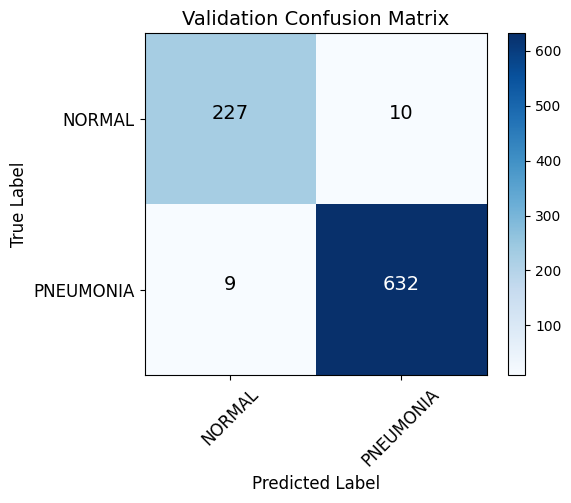

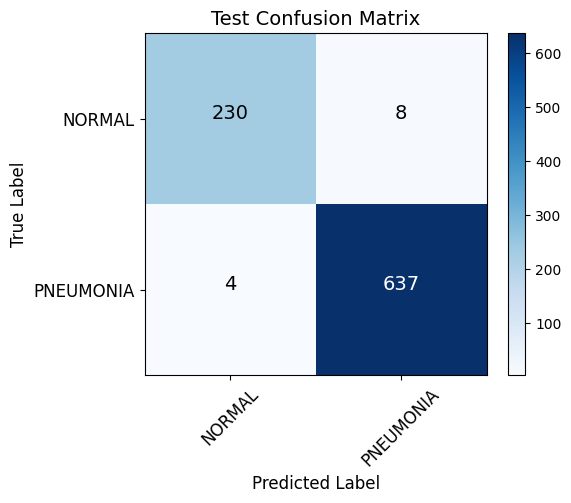

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, class_names, title):
    plt.figure(figsize=(6,5))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title(title, fontsize=14)
    plt.colorbar()

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, fontsize=12)
    plt.yticks(tick_marks, class_names, fontsize=12)

    # write numbers inside squares
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black",
                     fontsize=14)

    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()

# ==== Plot Validation Confusion Matrix ====
val_cm = confusion_matrix(val_truth, val_preds)
plot_confusion_matrix(val_cm, ["NORMAL", "PNEUMONIA"], "Validation Confusion Matrix")

# ==== Plot Test Confusion Matrix ====
test_cm = confusion_matrix(test_truth, test_preds)
plot_confusion_matrix(test_cm, ["NORMAL", "PNEUMONIA"], "Test Confusion Matrix")


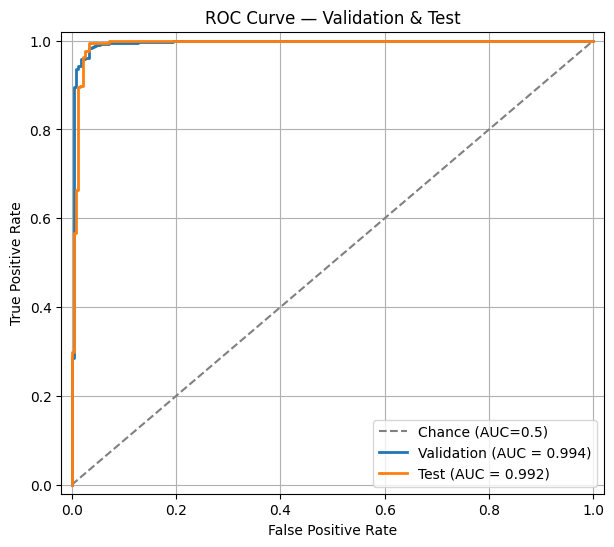

Validation AUC: 0.9944
Test AUC: 0.9924


In [4]:
# ====== ROC Curve Plot (Validation + Test) ======
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

def plot_roc_curve(y_true, y_probs, label, ax=None):
    """Plot ROC for one dataset on given axis; returns AUC or None if not computable."""
    # Must have both classes present
    if len(np.unique(y_true)) < 2:
        print(f"ROC/AUC cannot be computed for {label}: only one class present in labels.")
        return None
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    if ax is None:
        plt.figure(figsize=(6,6))
        ax = plt.gca()
    ax.plot(fpr, tpr, lw=2, label=f"{label} (AUC = {roc_auc:.3f})")
    return roc_auc

# Ensure you have these four variables from evaluate() calls:
# val_probs, val_truth  (lists/arrays of probabilities and true labels for validation)
# test_probs, test_truth (for test)
# If not, recompute by calling: _,_,_,_,_,_, val_probs, val_truth = evaluate(val_loader)

# Convert to numpy arrays
val_y = np.array(val_truth)
val_p = np.array(val_probs)
test_y = np.array(test_truth)
test_p = np.array(test_probs)

plt.figure(figsize=(7,6))
ax = plt.gca()
# plot chance line
ax.plot([0,1], [0,1], linestyle='--', color='grey', label='Chance (AUC=0.5)')

val_auc = plot_roc_curve(val_y, val_p, "Validation", ax=ax)
test_auc = plot_roc_curve(test_y, test_p, "Test", ax=ax)

ax.set_xlim([-0.02, 1.02])
ax.set_ylim([-0.02, 1.02])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve — Validation & Test')
ax.legend(loc='lower right')
ax.grid(True)
plt.show()

# Print numeric AUCs (if available)
if val_auc is not None:
    print(f"Validation AUC: {val_auc:.4f}")
if test_auc is not None:
    print(f"Test AUC: {test_auc:.4f}")


Device: cuda
Total images: 5856
Overall (NORMAL, PNEUMONIA): (1583, 4273)
Split sizes -> Train: 4099 Val: 878 Test: 879
Train (NORMAL,PNEUMONIA): (1108, 2991)
Val   (NORMAL,PNEUMONIA): (237, 641)
Test  (NORMAL,PNEUMONIA): (238, 641)
Showing 10 sample TRAIN images (true labels)...


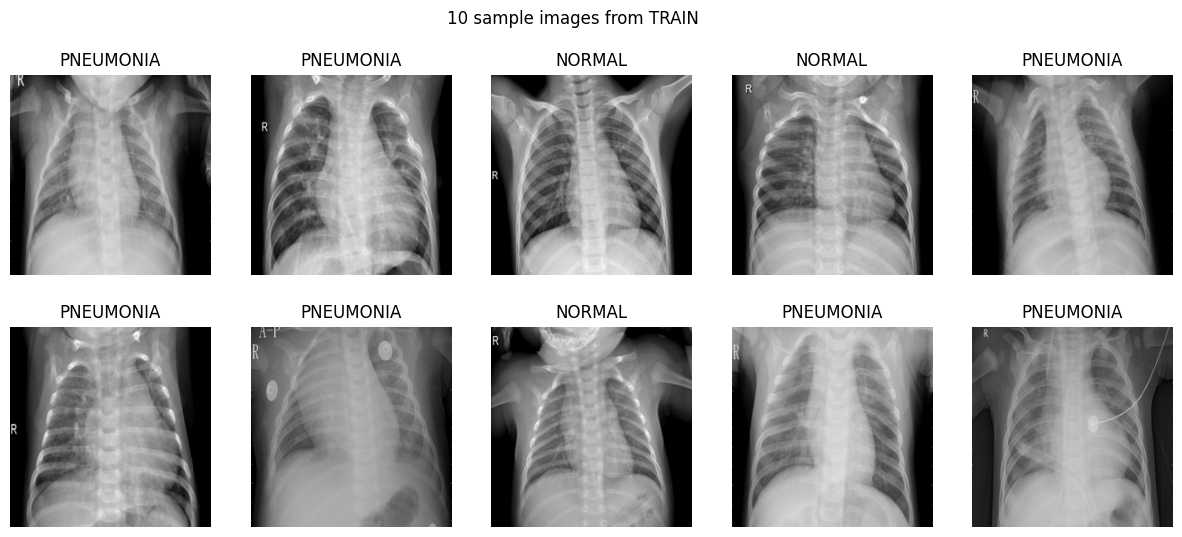

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 218MB/s]


Using ResNet-50


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 01/20 | Train loss: 0.2884 (eval_loss: 0.1493) AUC: 0.9073 | Val loss: 0.1742 AUC: 0.9868 Acc: 0.9385 F1: 0.9565
Saved best-by-accuracy model (Val Acc=0.9385) -> best_resnet50_by_acc_state_dict.pth
Epoch 02/20 | Train loss: 0.2263 (eval_loss: 0.0832) AUC: 0.9169 | Val loss: 0.1075 AUC: 0.9914 Acc: 0.9670 F1: 0.9775
Saved best-by-accuracy model (Val Acc=0.9670) -> best_resnet50_by_acc_state_dict.pth
Epoch 03/20 | Train loss: 0.1953 (eval_loss: 0.0840) AUC: 0.9221 | Val loss: 0.1128 AUC: 0.9926 Acc: 0.9590 F1: 0.9715
Epoch 04/20 | Train loss: 0.1995 (eval_loss: 0.1051) AUC: 0.9168 | Val loss: 0.1370 AUC: 0.9942 Acc: 0.9544 F1: 0.9679
Epoch 05/20 | Train loss: 0.1630 (eval_loss: 0.0535) AUC: 0.9534 | Val loss: 0.0837 AUC: 0.9949 Acc: 0.9715 F1: 0.9808
Saved best-by-accuracy model (Val Acc=0.9715) -> best_resnet50_by_acc_state_dict.pth
Epoch 06/20 | Train loss: 0.1646 (eval_loss: 0.0585) AUC: 0.9147 | Val loss: 0.1056 AUC: 0.9924 Acc: 0.9624 F1: 0.9737
Epoch 07/20 | Train loss: 0.160

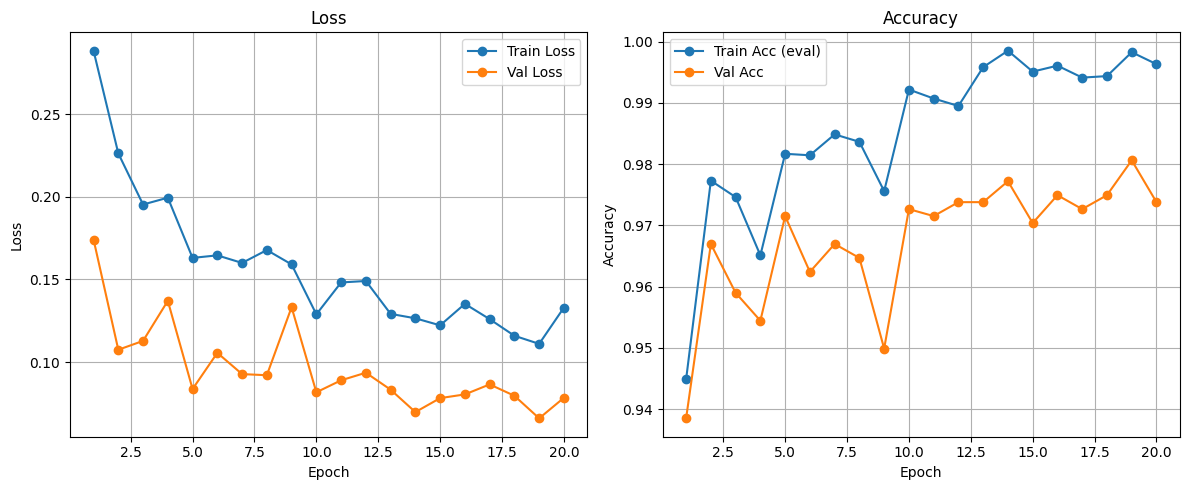

Loading best-by-accuracy state_dict for final reports...

=== VALIDATION Classification Report ===
              precision    recall  f1-score   support

      NORMAL       0.96      0.97      0.96       237
   PNEUMONIA       0.99      0.99      0.99       641

    accuracy                           0.98       878
   macro avg       0.97      0.98      0.98       878
weighted avg       0.98      0.98      0.98       878

Confusion Matrix (val):
 [[229   8]
 [  9 632]]

=== TEST Classification Report ===
              precision    recall  f1-score   support

      NORMAL       0.97      0.96      0.97       238
   PNEUMONIA       0.98      0.99      0.99       641

    accuracy                           0.98       879
   macro avg       0.98      0.97      0.98       879
weighted avg       0.98      0.98      0.98       879

Confusion Matrix (test):
 [[228  10]
 [  6 635]]
Done.


In [5]:
# pneumonia_resnet50_with_plots.py
import os
import glob
import random
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import warnings

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_auc_score, accuracy_score, precision_score,
                             recall_score, f1_score, confusion_matrix,
                             classification_report)

# ---------------- Config ----------------
BASE_DIR = "/kaggle/input/chest-xray-pneumonia/chest_xray"
SEED = 42
IMG_SIZE = 224
BATCH_SIZE = 16
NUM_EPOCHS = 20
LR = 1e-4
WEIGHT_DECAY = 1e-5
CHECKPOINT_BY_ACC = "best_resnet50_by_acc_state_dict.pth"
NUM_WORKERS = 2
USE_PIN_MEMORY = True

# MixUp / CutMix params
MIXUP_PROB = 0.5
CUTMIX_PROB = 0.5
MIXUP_ALPHA = 0.4
CUTMIX_ALPHA = 1.0

# reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

# ---------------- Transforms ----------------
class GrayToRGB(object):
    def __call__(self, img):
        if img.mode == "L":
            return img.convert("RGB")
        return img

train_transform = transforms.Compose([
    GrayToRGB(),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.85, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(12),
    transforms.ColorJitter(brightness=0.08, contrast=0.08),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225])
])

# Validation / eval transforms (no augmentation)
eval_transform = transforms.Compose([
    GrayToRGB(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225])
])

# --------------- Collect image paths & labels ---------------
train_paths = glob.glob(os.path.join(BASE_DIR, "train", "*", "*"))
val_paths   = glob.glob(os.path.join(BASE_DIR, "val", "*", "*"))
test_paths  = glob.glob(os.path.join(BASE_DIR, "test", "*", "*"))

all_paths = train_paths + val_paths + test_paths
all_paths = [p for p in all_paths if p.lower().endswith((".png", ".jpg", ".jpeg"))]

if len(all_paths) == 0:
    raise FileNotFoundError(f"No images found under {BASE_DIR}. Run `!ls -R {BASE_DIR}` to inspect.")

def label_from_path(p):
    parent = Path(p).parent.name
    return 1 if parent.lower() == "pneumonia" else 0

all_labels = [label_from_path(p) for p in all_paths]

print("Total images:", len(all_paths))
print("Overall (NORMAL, PNEUMONIA):", (sum(1 for l in all_labels if l==0), sum(1 for l in all_labels if l==1)))

# --------------- Stratified split 70/15/15 ---------------
train_files, temp_files, train_labels, temp_labels = train_test_split(
    all_paths, all_labels, test_size=0.30, random_state=SEED, stratify=all_labels
)
val_files, test_files, val_labels, test_labels = train_test_split(
    temp_files, temp_labels, test_size=0.5, random_state=SEED, stratify=temp_labels
)

print("Split sizes -> Train:", len(train_files), "Val:", len(val_files), "Test:", len(test_files))
print("Train (NORMAL,PNEUMONIA):", (sum(1 for l in train_labels if l==0), sum(1 for l in train_labels if l==1)))
print("Val   (NORMAL,PNEUMONIA):", (sum(1 for l in val_labels if l==0), sum(1 for l in val_labels if l==1)))
print("Test  (NORMAL,PNEUMONIA):", (sum(1 for l in test_labels if l==0), sum(1 for l in test_labels if l==1)))

# --------------- Show 10 sample images from TRAIN ---------------
def show_samples(file_list, n=10, seed=SEED):
    n = min(n, len(file_list))
    random.seed(seed)
    sample = random.sample(file_list, n)
    cols = 5
    rows = (n + cols - 1) // cols
    plt.figure(figsize=(cols*3, rows*3))
    for i, p in enumerate(sample):
        img = Image.open(p).convert("RGB").resize((IMG_SIZE, IMG_SIZE))
        label = "PNEUMONIA" if Path(p).parent.name.lower() == "pneumonia" else "NORMAL"
        plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.title(label)
        plt.axis("off")
    plt.suptitle(f"{n} sample images from TRAIN")
    plt.show()

print("Showing 10 sample TRAIN images (true labels)...")
show_samples(train_files, n=10)

# --------------- Dataset class ---------------
class PneumoniaDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform
    def __len__(self):
        return len(self.file_list)
    def __getitem__(self, idx):
        path = self.file_list[idx]
        parent = Path(path).parent.name
        label = 1 if parent.lower() == "pneumonia" else 0
        img = Image.open(path)
        if self.transform:
            img = self.transform(img)
        return img, label

# --------------- Dataloaders ---------------
train_ds = PneumoniaDataset(train_files, transform=train_transform)
# for computing true train accuracy/loss without augmentation:
train_eval_ds = PneumoniaDataset(train_files, transform=eval_transform)

val_ds   = PneumoniaDataset(val_files,   transform=eval_transform)
test_ds  = PneumoniaDataset(test_files,  transform=eval_transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=USE_PIN_MEMORY)
train_eval_loader = DataLoader(train_eval_ds, batch_size=BATCH_SIZE, shuffle=False,
                               num_workers=NUM_WORKERS, pin_memory=USE_PIN_MEMORY)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=USE_PIN_MEMORY)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=USE_PIN_MEMORY)

# --------------- Model: ResNet50 (pretrained) ---------------
def get_resnet50(num_classes=2):
    weights_cls = getattr(models, "ResNet50_Weights", None)
    if weights_cls is not None:
        model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
    else:
        model = models.resnet50(pretrained=True)
    in_f = model.fc.in_features
    model.fc = nn.Linear(in_f, num_classes)
    return model

model = get_resnet50(num_classes=2).to(DEVICE)
print("Using ResNet-50")

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=False)

# --------------- MixUp & CutMix helpers ---------------
def rand_bbox(size, lam):
    W = size[3]; H = size[2]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)
    cx = np.random.randint(W); cy = np.random.randint(H)
    x1 = np.clip(cx - cut_w // 2, 0, W); y1 = np.clip(cy - cut_h // 2, 0, H)
    x2 = np.clip(cx + cut_w // 2, 0, W); y2 = np.clip(cy + cut_h // 2, 0, H)
    return x1, y1, x2, y2

def mixup_data(x, y, alpha=MIXUP_ALPHA):
    if alpha <= 0: return x, y, y, 1.0
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    return mixed_x, y, y[index], lam

def cutmix_data(x, y, alpha=CUTMIX_ALPHA):
    if alpha <= 0: return x, y, y, 1.0
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    x1 = x.clone(); x2 = x[index, :]
    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
    x1[:, :, bby1:bby2, bbx1:bbx2] = x2[:, :, bby1:bby2, bbx1:bbx2]
    lam_adj = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size(-1) * x.size(-2) + 1e-8))
    return x1, y, y[index], lam_adj

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# --------------- Training & Evaluation helpers ---------------
def train_one_epoch():
    model.train()
    running_loss = 0.0
    all_labels, all_probs = [], []
    for imgs, labels in train_loader:
        imgs = imgs.to(DEVICE); labels = labels.to(DEVICE)
        if random.random() < MIXUP_PROB:
            if random.random() < CUTMIX_PROB:
                imgs_m, ya, yb, lam = cutmix_data(imgs, labels)
            else:
                imgs_m, ya, yb, lam = mixup_data(imgs, labels)
            outputs = model(imgs_m)
            loss = mixup_criterion(criterion, outputs, ya, yb, lam)
            probs = torch.softmax(outputs, dim=1)[:,1].detach().cpu().numpy()
        else:
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            probs = torch.softmax(outputs, dim=1)[:,1].detach().cpu().numpy()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        all_probs.extend(probs.tolist())
        all_labels.extend(labels.cpu().numpy().tolist())

    avg_loss = running_loss / len(train_ds)
    auc = roc_auc_score(all_labels, all_probs) if len(set(all_labels)) > 1 else float('nan')
    return avg_loss, auc

def evaluate(loader):
    model.eval()
    running_loss = 0.0
    all_labels, all_probs = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(DEVICE); labels = labels.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * imgs.size(0)
            probs = torch.softmax(outputs, dim=1)[:,1].cpu().numpy()
            all_probs.extend(probs.tolist())
            all_labels.extend(labels.cpu().numpy().tolist())
    avg_loss = running_loss / (len(loader.dataset))
    auc = roc_auc_score(all_labels, all_probs) if len(set(all_labels)) > 1 else float('nan')
    preds = [1 if p >= 0.5 else 0 for p in all_probs]
    acc = accuracy_score(all_labels, preds)
    prec = precision_score(all_labels, preds, zero_division=0)
    rec = recall_score(all_labels, preds, zero_division=0)
    f1 = f1_score(all_labels, preds, zero_division=0)
    return avg_loss, auc, acc, prec, rec, f1, all_probs, all_labels

# --------------- History tracking for plots ---------------
history_train_loss = []
history_val_loss = []
history_train_acc = []
history_val_acc = []

# --------------- Train loop (save best by VAL accuracy) ---------------
best_val_acc = -1.0
for epoch in range(1, NUM_EPOCHS+1):
    train_loss, train_auc = train_one_epoch()
    # compute true train eval metrics on eval_transform (no augmentation)
    train_eval_loss, train_eval_auc, train_eval_acc, _, _, _, _, _ = evaluate(train_eval_loader)
    val_loss, val_auc, val_acc, val_prec, val_rec, val_f1, _, _ = evaluate(val_loader)

    # record history
    history_train_loss.append(train_loss)
    history_val_loss.append(val_loss)
    history_train_acc.append(train_eval_acc)
    history_val_acc.append(val_acc)

    ta = f"{train_auc:.4f}" if not np.isnan(train_auc) else "-"
    va = f"{val_auc:.4f}" if not np.isnan(val_auc) else "-"
    print(f"Epoch {epoch:02d}/{NUM_EPOCHS} | Train loss: {train_loss:.4f} (eval_loss: {train_eval_loss:.4f}) AUC: {ta} | "
          f"Val loss: {val_loss:.4f} AUC: {va} Acc: {val_acc:.4f} F1: {val_f1:.4f}")

    # Save best by val accuracy (state_dict)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), CHECKPOINT_BY_ACC)
        print(f"Saved best-by-accuracy model (Val Acc={val_acc:.4f}) -> {CHECKPOINT_BY_ACC}")

    if not np.isnan(val_auc):
        scheduler.step(val_auc)

# --------------- Plot Loss & Accuracy curves ---------------
epochs = range(1, len(history_train_loss)+1)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, history_train_loss, label="Train Loss", marker='o')
plt.plot(epochs, history_val_loss, label="Val Loss", marker='o')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(epochs, history_train_acc, label="Train Acc (eval)", marker='o')
plt.plot(epochs, history_val_acc, label="Val Acc", marker='o')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# --------------- After training: load best state_dict and show reports ---------------
print("Loading best-by-accuracy state_dict for final reports...")
if os.path.exists(CHECKPOINT_BY_ACC):
    sd = torch.load(CHECKPOINT_BY_ACC, map_location=DEVICE)
    model.load_state_dict(sd)
else:
    print("No saved checkpoint found; using current model weights.")

# Validation report
_, _, val_acc, _, _, _, val_probs, val_truth = evaluate(val_loader)
val_preds = [1 if p >= 0.5 else 0 for p in val_probs]
print("\n=== VALIDATION Classification Report ===")
print(classification_report(val_truth, val_preds, target_names=["NORMAL","PNEUMONIA"]))
print("Confusion Matrix (val):\n", confusion_matrix(val_truth, val_preds))

# Test report
_, _, test_acc, _, _, _, test_probs, test_truth = evaluate(test_loader)
test_preds = [1 if p >= 0.5 else 0 for p in test_probs]
print("\n=== TEST Classification Report ===")
print(classification_report(test_truth, test_preds, target_names=["NORMAL","PNEUMONIA"]))
print("Confusion Matrix (test):\n", confusion_matrix(test_truth, test_preds))

print("Done.")


/tmp/ipykernel_20/3805757903.py:40: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


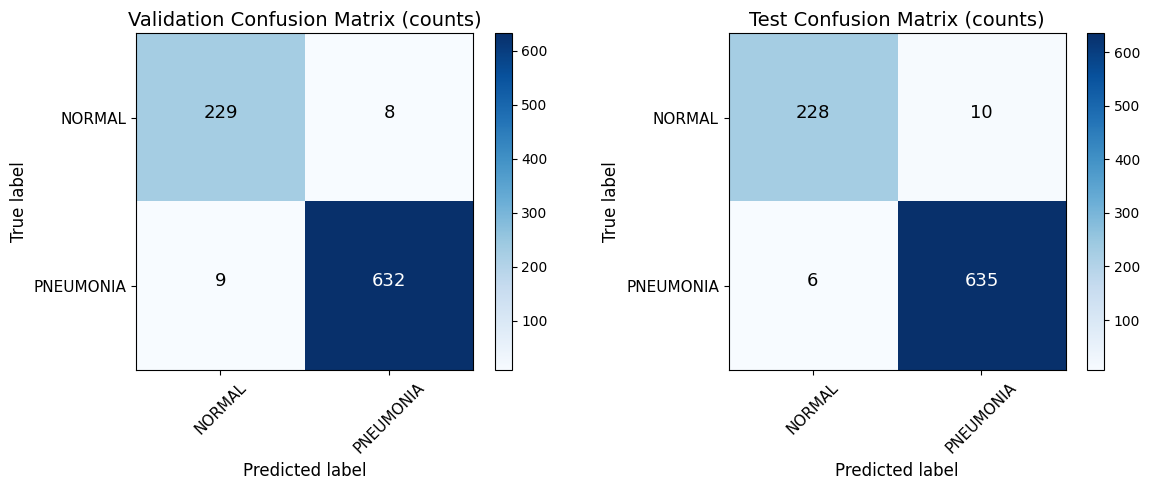

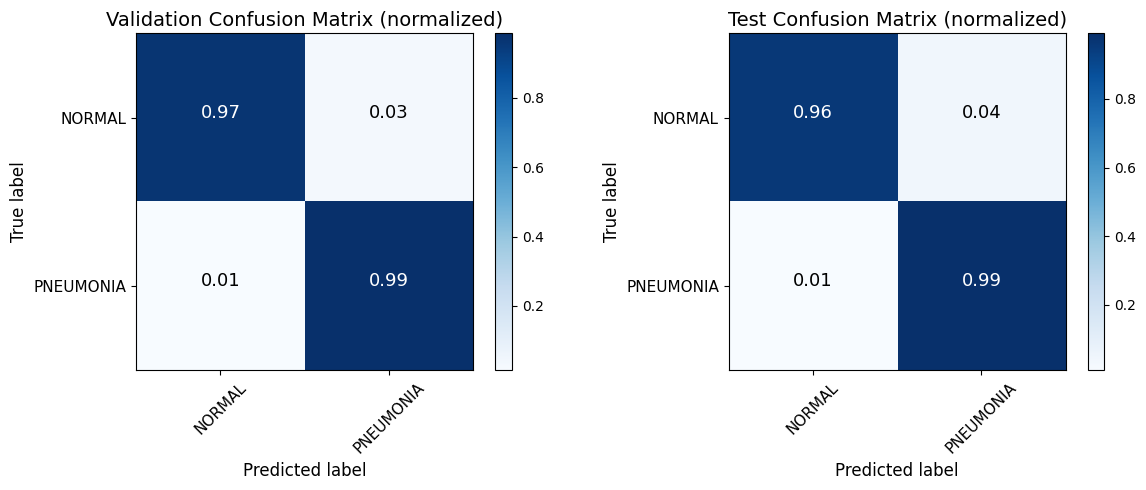

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, class_names, title, normalize=False):
    """
    cm: 2x2 confusion matrix (np.array)
    class_names: list like ["NORMAL","PNEUMONIA"]
    normalize: if True, show percentages instead of counts
    """
    if normalize:
        cm_sum = cm.sum(axis=1, keepdims=True)
        cm_disp = cm.astype('float') / (cm_sum + 1e-8)
    else:
        cm_disp = cm

    plt.imshow(cm_disp, interpolation='nearest', cmap='Blues')
    plt.title(title, fontsize=14)
    plt.colorbar(fraction=0.046, pad=0.04)

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, fontsize=11)
    plt.yticks(tick_marks, class_names, fontsize=11)

    fmt = '.2f' if normalize else 'd'
    thresh = cm_disp.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            val = cm_disp[i, j]
            if normalize:
                txt = format(val, fmt)
            else:
                txt = format(int(cm[i, j]), fmt)
            plt.text(j, i, txt,
                     horizontalalignment="center",
                     color="white" if cm_disp[i, j] > thresh else "black",
                     fontsize=13)

    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.tight_layout()

# compute confusion matrices (you already printed them earlier)
val_cm = confusion_matrix(val_truth, val_preds)
test_cm = confusion_matrix(test_truth, test_preds)

# plot side-by-side (counts)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plot_confusion_matrix(val_cm, ["NORMAL","PNEUMONIA"], "Validation Confusion Matrix (counts)", normalize=False)
plt.subplot(1,2,2)
plot_confusion_matrix(test_cm, ["NORMAL","PNEUMONIA"], "Test Confusion Matrix (counts)", normalize=False)
plt.show()

# plot side-by-side (normalized by true class -> recall per class)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plot_confusion_matrix(val_cm, ["NORMAL","PNEUMONIA"], "Validation Confusion Matrix (normalized)", normalize=True)
plt.subplot(1,2,2)
plot_confusion_matrix(test_cm, ["NORMAL","PNEUMONIA"], "Test Confusion Matrix (normalized)", normalize=True)
plt.show()


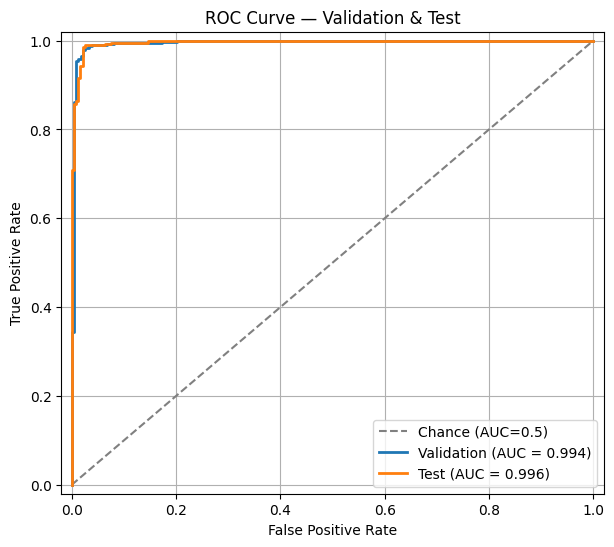

Validation AUC: 0.9945
Test AUC: 0.9959


In [7]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

def plot_roc(ax, y_true, y_prob, label):
    """Plot ROC curve for a dataset, return AUC."""
    # Must contain both positive and negative classes
    if len(np.unique(y_true)) < 2:
        print(f"Cannot compute ROC for {label}: only one class present.")
        return None

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, lw=2, label=f"{label} (AUC = {roc_auc:.3f})")
    return roc_auc

# Convert to numpy arrays
val_y = np.array(val_truth)
val_p = np.array(val_probs)
test_y = np.array(test_truth)
test_p = np.array(test_probs)

plt.figure(figsize=(7,6))
ax = plt.gca()

# chance line
ax.plot([0,1], [0,1], linestyle='--', color='gray', label='Chance (AUC=0.5)')

# plot validation & test ROC
val_auc = plot_roc(ax, val_y, val_p, "Validation")
test_auc = plot_roc(ax, test_y, test_p, "Test")

ax.set_xlim([-0.02, 1.02])
ax.set_ylim([-0.02, 1.02])
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curve — Validation & Test")
ax.legend(loc="lower right")
ax.grid(True)
plt.show()

# print AUC numbers
if val_auc is not None:
    print(f"Validation AUC: {val_auc:.4f}")
if test_auc is not None:
    print(f"Test AUC: {test_auc:.4f}")


Device: cuda
Total images: 5856
Overall (NORMAL, PNEUMONIA): (1583, 4273)
Split sizes -> Train: 4099 Val: 878 Test: 879
Train (NORMAL,PNEUMONIA): (1108, 2991)
Val   (NORMAL,PNEUMONIA): (237, 641)
Test  (NORMAL,PNEUMONIA): (238, 641)
Showing 10 sample TRAIN images (true labels)...


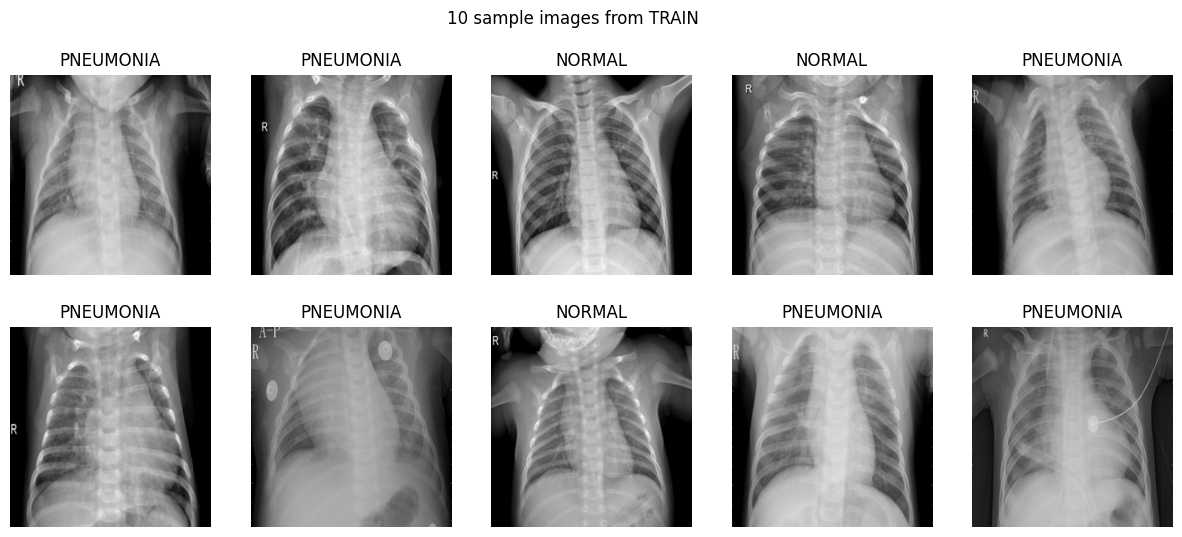

Using ResNet-50 Multi-head model


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 01/20 | Train loss: 0.4164 (eval_loss: 0.1333) AUC: 0.9064 | Val loss: 0.1454 AUC: 0.9916 Acc: 0.9601 F1: 0.9725
Saved best-by-accuracy model (Val Acc=0.9601) -> best_resnet50_multihead_by_acc_state_dict.pth
Epoch 02/20 | Train loss: 0.3243 (eval_loss: 0.1130) AUC: 0.9208 | Val loss: 0.1306 AUC: 0.9924 Acc: 0.9624 F1: 0.9747
Saved best-by-accuracy model (Val Acc=0.9624) -> best_resnet50_multihead_by_acc_state_dict.pth
Epoch 03/20 | Train loss: 0.2756 (eval_loss: 0.1232) AUC: 0.9211 | Val loss: 0.1467 AUC: 0.9933 Acc: 0.9487 F1: 0.9639
Epoch 04/20 | Train loss: 0.2787 (eval_loss: 0.0828) AUC: 0.9373 | Val loss: 0.1071 AUC: 0.9941 Acc: 0.9704 F1: 0.9795
Saved best-by-accuracy model (Val Acc=0.9704) -> best_resnet50_multihead_by_acc_state_dict.pth
Epoch 05/20 | Train loss: 0.2382 (eval_loss: 0.0565) AUC: 0.9478 | Val loss: 0.0808 AUC: 0.9942 Acc: 0.9749 F1: 0.9829
Saved best-by-accuracy model (Val Acc=0.9749) -> best_resnet50_multihead_by_acc_state_dict.pth
Epoch 06/20 | Train loss:

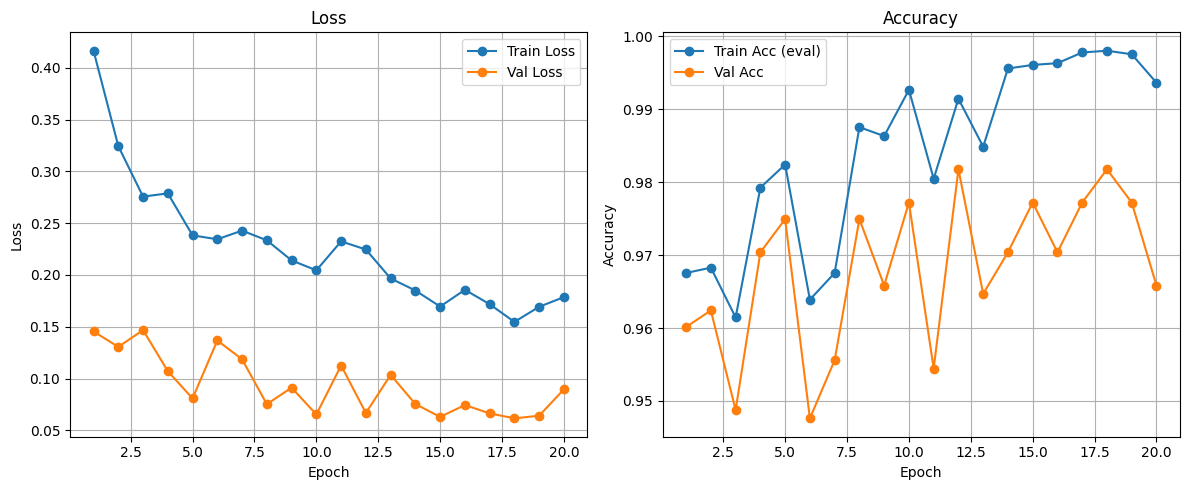

Loading best-by-accuracy state_dict for final reports...

=== VALIDATION Classification Report ===
              precision    recall  f1-score   support

      NORMAL       0.95      0.99      0.97       237
   PNEUMONIA       1.00      0.98      0.99       641

    accuracy                           0.98       878
   macro avg       0.97      0.98      0.98       878
weighted avg       0.98      0.98      0.98       878

Confusion Matrix (val):
 [[234   3]
 [ 13 628]]

=== TEST Classification Report ===
              precision    recall  f1-score   support

      NORMAL       0.94      0.97      0.96       238
   PNEUMONIA       0.99      0.98      0.98       641

    accuracy                           0.98       879
   macro avg       0.97      0.97      0.97       879
weighted avg       0.98      0.98      0.98       879

Confusion Matrix (test):
 [[231   7]
 [ 14 627]]


/tmp/ipykernel_20/292571014.py:407: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


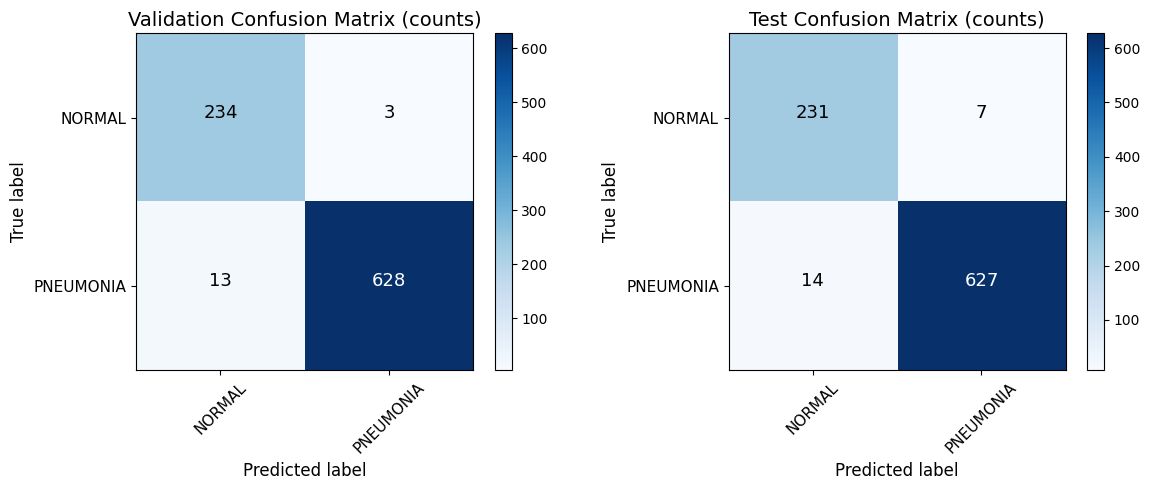

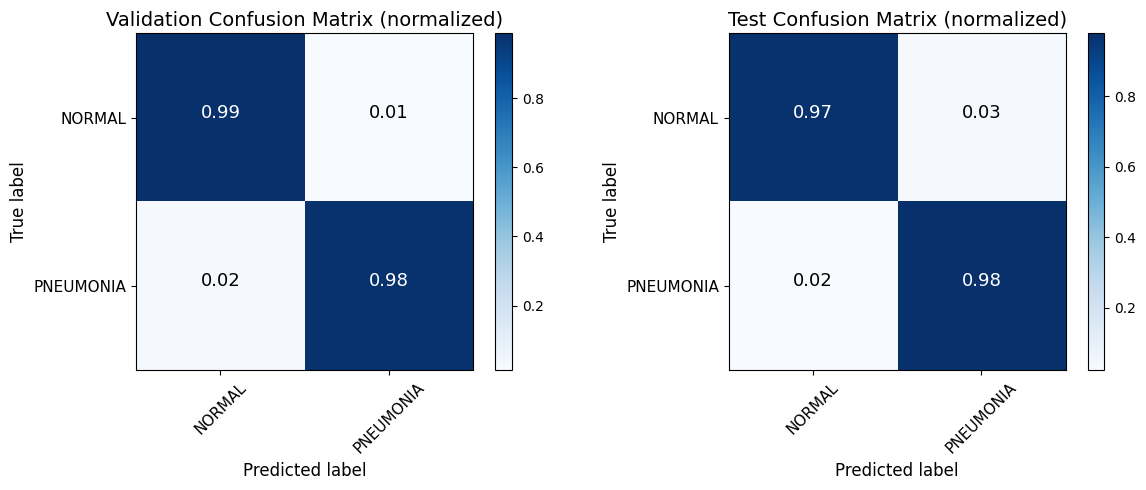

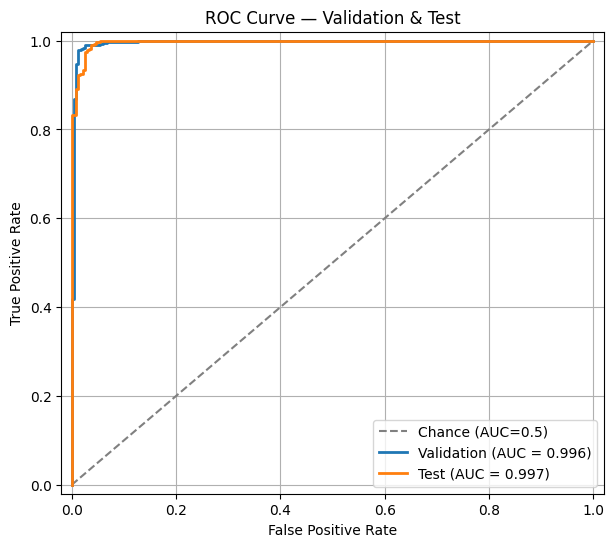

Validation AUC: 0.9959
Test AUC: 0.9968
Done.


In [8]:
# pneumonia_resnet50_multihead.py
import os
import glob
import random
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import warnings

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_auc_score, accuracy_score, precision_score,
                             recall_score, f1_score, confusion_matrix,
                             classification_report, roc_curve, auc)

# ---------------- Config ----------------
BASE_DIR = "/kaggle/input/chest-xray-pneumonia/chest_xray"
SEED = 42
IMG_SIZE = 224
BATCH_SIZE = 16
NUM_EPOCHS = 20
LR = 1e-4
WEIGHT_DECAY = 1e-5
CHECKPOINT_BY_ACC = "best_resnet50_multihead_by_acc_state_dict.pth"
NUM_WORKERS = 2
USE_PIN_MEMORY = True

# MixUp / CutMix params
MIXUP_PROB = 0.5
CUTMIX_PROB = 0.5
MIXUP_ALPHA = 0.4
CUTMIX_ALPHA = 1.0

# Auxiliary head weight in total loss
AUX_WEIGHT = 0.4

# reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

# ---------------- Transforms ----------------
class GrayToRGB(object):
    def __call__(self, img):
        if img.mode == "L":
            return img.convert("RGB")
        return img

train_transform = transforms.Compose([
    GrayToRGB(),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.85, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(12),
    transforms.ColorJitter(brightness=0.08, contrast=0.08),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225])
])

# Validation / eval transforms (no augmentation)
eval_transform = transforms.Compose([
    GrayToRGB(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225])
])

# --------------- Collect image paths & labels ---------------
train_paths = glob.glob(os.path.join(BASE_DIR, "train", "*", "*"))
val_paths   = glob.glob(os.path.join(BASE_DIR, "val", "*", "*"))
test_paths  = glob.glob(os.path.join(BASE_DIR, "test", "*", "*"))

all_paths = train_paths + val_paths + test_paths
all_paths = [p for p in all_paths if p.lower().endswith((".png", ".jpg", ".jpeg"))]

if len(all_paths) == 0:
    raise FileNotFoundError(f"No images found under {BASE_DIR}. Run `!ls -R {BASE_DIR}` to inspect.")

def label_from_path(p):
    parent = Path(p).parent.name
    return 1 if parent.lower() == "pneumonia" else 0

all_labels = [label_from_path(p) for p in all_paths]

print("Total images:", len(all_paths))
print("Overall (NORMAL, PNEUMONIA):", (sum(1 for l in all_labels if l==0), sum(1 for l in all_labels if l==1)))

# --------------- Stratified split 70/15/15 ---------------
train_files, temp_files, train_labels, temp_labels = train_test_split(
    all_paths, all_labels, test_size=0.30, random_state=SEED, stratify=all_labels
)
val_files, test_files, val_labels, test_labels = train_test_split(
    temp_files, temp_labels, test_size=0.5, random_state=SEED, stratify=temp_labels
)

print("Split sizes -> Train:", len(train_files), "Val:", len(val_files), "Test:", len(test_files))
print("Train (NORMAL,PNEUMONIA):", (sum(1 for l in train_labels if l==0), sum(1 for l in train_labels if l==1)))
print("Val   (NORMAL,PNEUMONIA):", (sum(1 for l in val_labels if l==0), sum(1 for l in val_labels if l==1)))
print("Test  (NORMAL,PNEUMONIA):", (sum(1 for l in test_labels if l==0), sum(1 for l in test_labels if l==1)))

# --------------- Show 10 sample images from TRAIN ---------------
def show_samples(file_list, n=10, seed=SEED):
    n = min(n, len(file_list))
    random.seed(seed)
    sample = random.sample(file_list, n)
    cols = 5
    rows = (n + cols - 1) // cols
    plt.figure(figsize=(cols*3, rows*3))
    for i, p in enumerate(sample):
        img = Image.open(p).convert("RGB").resize((IMG_SIZE, IMG_SIZE))
        label = "PNEUMONIA" if Path(p).parent.name.lower() == "pneumonia" else "NORMAL"
        plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.title(label)
        plt.axis("off")
    plt.suptitle(f"{n} sample images from TRAIN")
    plt.show()

print("Showing 10 sample TRAIN images (true labels)...")
show_samples(train_files, n=10)

# --------------- Dataset class ---------------
class PneumoniaDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform
    def __len__(self):
        return len(self.file_list)
    def __getitem__(self, idx):
        path = self.file_list[idx]
        parent = Path(path).parent.name
        label = 1 if parent.lower() == "pneumonia" else 0
        img = Image.open(path)
        if self.transform:
            img = self.transform(img)
        return img, label

# --------------- Dataloaders ---------------
train_ds = PneumoniaDataset(train_files, transform=train_transform)
# for computing true train accuracy/loss without augmentation:
train_eval_ds = PneumoniaDataset(train_files, transform=eval_transform)

val_ds   = PneumoniaDataset(val_files,   transform=eval_transform)
test_ds  = PneumoniaDataset(test_files,  transform=eval_transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=USE_PIN_MEMORY)
train_eval_loader = DataLoader(train_eval_ds, batch_size=BATCH_SIZE, shuffle=False,
                               num_workers=NUM_WORKERS, pin_memory=USE_PIN_MEMORY)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=USE_PIN_MEMORY)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=USE_PIN_MEMORY)

# --------------- Multi-head ResNet-50 model ---------------
class ResNet50MultiHead(nn.Module):
    def __init__(self, num_classes=2, aux_weight=0.4, pretrained=True):
        super().__init__()
        # load pretrained resnet50
        weights_cls = getattr(models, "ResNet50_Weights", None)
        if weights_cls is not None and pretrained:
            base = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        else:
            base = models.resnet50(pretrained=pretrained)
        # remove final fc, keep everything else
        self.backbone = nn.Sequential(*list(base.children())[:-1])  # up to avgpool
        feat_dim = base.fc.in_features  # usually 2048
        # two heads
        self.head_main = nn.Linear(feat_dim, num_classes)   # head A (main)
        self.head_aux  = nn.Linear(feat_dim, num_classes)   # head B (auxiliary)
        self.aux_weight = aux_weight

    def forward(self, x):
        # x -> backbone -> (B, feat_dim, 1, 1) after global pool
        feat = self.backbone(x)           # shape: B x feat_dim x 1 x 1
        feat = feat.view(feat.size(0), -1)  # B x feat_dim
        out_main = self.head_main(feat)
        out_aux  = self.head_aux(feat)
        return out_main, out_aux

# instantiate model
model = ResNet50MultiHead(num_classes=2, aux_weight=AUX_WEIGHT, pretrained=True).to(DEVICE)
print("Using ResNet-50 Multi-head model")

# --------------- Loss / Optimizer / Scheduler ---------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=False)

# --------------- MixUp & CutMix helpers ---------------
def rand_bbox(size, lam):
    W = size[3]; H = size[2]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)
    cx = np.random.randint(W); cy = np.random.randint(H)
    x1 = np.clip(cx - cut_w // 2, 0, W); y1 = np.clip(cy - cut_h // 2, 0, H)
    x2 = np.clip(cx + cut_w // 2, 0, W); y2 = np.clip(cy + cut_h // 2, 0, H)
    return x1, y1, x2, y2

def mixup_data(x, y, alpha=MIXUP_ALPHA):
    if alpha <= 0: return x, y, y, 1.0
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    return mixed_x, y, y[index], lam

def cutmix_data(x, y, alpha=CUTMIX_ALPHA):
    if alpha <= 0: return x, y, y, 1.0
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    x1 = x.clone(); x2 = x[index, :]
    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
    x1[:, :, bby1:bby2, bbx1:bbx2] = x2[:, :, bby1:bby2, bbx1:bbx2]
    lam_adj = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size(-1) * x.size(-2) + 1e-8))
    return x1, y, y[index], lam_adj

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# --------------- Training & Evaluation helpers ---------------
def train_one_epoch():
    model.train()
    running_loss = 0.0
    all_labels, all_probs = [], []
    for imgs, labels in train_loader:
        imgs = imgs.to(DEVICE); labels = labels.to(DEVICE)
        # Apply MixUp/CutMix randomly
        if random.random() < MIXUP_PROB:
            if random.random() < CUTMIX_PROB:
                imgs_m, ya, yb, lam = cutmix_data(imgs, labels)
            else:
                imgs_m, ya, yb, lam = mixup_data(imgs, labels)
            out_main, out_aux = model(imgs_m)
            loss_main = mixup_criterion(criterion, out_main, ya, yb, lam)
            loss_aux  = mixup_criterion(criterion, out_aux,  ya, yb, lam)
            loss = loss_main + model.aux_weight * loss_aux
            probs = torch.softmax(out_main, dim=1)[:,1].detach().cpu().numpy()
        else:
            out_main, out_aux = model(imgs)
            loss_main = criterion(out_main, labels)
            loss_aux  = criterion(out_aux, labels)
            loss = loss_main + model.aux_weight * loss_aux
            probs = torch.softmax(out_main, dim=1)[:,1].detach().cpu().numpy()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        all_probs.extend(probs.tolist())
        all_labels.extend(labels.cpu().numpy().tolist())

    avg_loss = running_loss / len(train_ds)
    auc = roc_auc_score(all_labels, all_probs) if len(set(all_labels)) > 1 else float('nan')
    return avg_loss, auc

def evaluate(loader, use_main_head=True):
    """
    Evaluate using the main head by default. Returns:
    avg_loss, auc, acc, prec, rec, f1, probs, labels
    """
    model.eval()
    running_loss = 0.0
    all_labels, all_probs = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(DEVICE); labels = labels.to(DEVICE)
            out_main, out_aux = model(imgs)
            # For evaluation we compute loss on main head only (optionally could include aux)
            loss = criterion(out_main, labels)
            running_loss += loss.item() * imgs.size(0)
            probs = torch.softmax(out_main, dim=1)[:,1].cpu().numpy()
            all_probs.extend(probs.tolist())
            all_labels.extend(labels.cpu().numpy().tolist())
    avg_loss = running_loss / (len(loader.dataset))
    auc = roc_auc_score(all_labels, all_probs) if len(set(all_labels)) > 1 else float('nan')
    preds = [1 if p >= 0.5 else 0 for p in all_probs]
    acc = accuracy_score(all_labels, preds)
    prec = precision_score(all_labels, preds, zero_division=0)
    rec = recall_score(all_labels, preds, zero_division=0)
    f1 = f1_score(all_labels, preds, zero_division=0)
    return avg_loss, auc, acc, prec, rec, f1, all_probs, all_labels

# --------------- History tracking for plots ---------------
history_train_loss = []
history_val_loss = []
history_train_acc = []
history_val_acc = []

# --------------- Train loop (save best by VAL accuracy) ---------------
best_val_acc = -1.0
for epoch in range(1, NUM_EPOCHS+1):
    train_loss, train_auc = train_one_epoch()
    # compute true train eval metrics on eval_transform (no augmentation)
    train_eval_loss, train_eval_auc, train_eval_acc, _, _, _, _, _ = evaluate(train_eval_loader)
    val_loss, val_auc, val_acc, val_prec, val_rec, val_f1, _, _ = evaluate(val_loader)

    # record history
    history_train_loss.append(train_loss)
    history_val_loss.append(val_loss)
    history_train_acc.append(train_eval_acc)
    history_val_acc.append(val_acc)

    ta = f"{train_auc:.4f}" if not np.isnan(train_auc) else "-"
    va = f"{val_auc:.4f}" if not np.isnan(val_auc) else "-"
    print(f"Epoch {epoch:02d}/{NUM_EPOCHS} | Train loss: {train_loss:.4f} (eval_loss: {train_eval_loss:.4f}) AUC: {ta} | "
          f"Val loss: {val_loss:.4f} AUC: {va} Acc: {val_acc:.4f} F1: {val_f1:.4f}")

    # Save best by val accuracy (state_dict)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), CHECKPOINT_BY_ACC)
        print(f"Saved best-by-accuracy model (Val Acc={val_acc:.4f}) -> {CHECKPOINT_BY_ACC}")

    if not np.isnan(val_auc):
        scheduler.step(val_auc)

# --------------- Plot Loss & Accuracy curves ---------------
epochs = range(1, len(history_train_loss)+1)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, history_train_loss, label="Train Loss", marker='o')
plt.plot(epochs, history_val_loss, label="Val Loss", marker='o')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(epochs, history_train_acc, label="Train Acc (eval)", marker='o')
plt.plot(epochs, history_val_acc, label="Val Acc", marker='o')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# --------------- After training: load best state_dict and show reports ---------------
print("Loading best-by-accuracy state_dict for final reports...")
if os.path.exists(CHECKPOINT_BY_ACC):
    sd = torch.load(CHECKPOINT_BY_ACC, map_location=DEVICE)
    model.load_state_dict(sd)
else:
    print("No saved checkpoint found; using current model weights.")

# Validation report
_, _, val_acc, _, _, _, val_probs, val_truth = evaluate(val_loader)
val_preds = [1 if p >= 0.5 else 0 for p in val_probs]
print("\n=== VALIDATION Classification Report ===")
print(classification_report(val_truth, val_preds, target_names=["NORMAL","PNEUMONIA"]))
print("Confusion Matrix (val):\n", confusion_matrix(val_truth, val_preds))

# Test report
_, _, test_acc, _, _, _, test_probs, test_truth = evaluate(test_loader)
test_preds = [1 if p >= 0.5 else 0 for p in test_probs]
print("\n=== TEST Classification Report ===")
print(classification_report(test_truth, test_preds, target_names=["NORMAL","PNEUMONIA"]))
print("Confusion Matrix (test):\n", confusion_matrix(test_truth, test_preds))

# --------------- Plot Confusion Matrices (counts + normalized) ---------------
def plot_confusion_matrix(cm, class_names, title, normalize=False):
    if normalize:
        cm_sum = cm.sum(axis=1, keepdims=True)
        cm_disp = cm.astype('float') / (cm_sum + 1e-8)
    else:
        cm_disp = cm

    plt.imshow(cm_disp, interpolation='nearest', cmap='Blues')
    plt.title(title, fontsize=14)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, fontsize=11)
    plt.yticks(tick_marks, class_names, fontsize=11)
    fmt = '.2f' if normalize else 'd'
    thresh = cm_disp.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            val = cm_disp[i, j]
            if normalize:
                txt = format(val, fmt)
            else:
                txt = format(int(cm[i, j]), fmt)
            plt.text(j, i, txt,
                     horizontalalignment="center",
                     color="white" if cm_disp[i, j] > thresh else "black",
                     fontsize=13)
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.tight_layout()

val_cm = confusion_matrix(val_truth, val_preds)
test_cm = confusion_matrix(test_truth, test_preds)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plot_confusion_matrix(val_cm, ["NORMAL","PNEUMONIA"], "Validation Confusion Matrix (counts)", normalize=False)
plt.subplot(1,2,2)
plot_confusion_matrix(test_cm, ["NORMAL","PNEUMONIA"], "Test Confusion Matrix (counts)", normalize=False)
plt.show()

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plot_confusion_matrix(val_cm, ["NORMAL","PNEUMONIA"], "Validation Confusion Matrix (normalized)", normalize=True)
plt.subplot(1,2,2)
plot_confusion_matrix(test_cm, ["NORMAL","PNEUMONIA"], "Test Confusion Matrix (normalized)", normalize=True)
plt.show()

# --------------- ROC Curve (Validation & Test) ---------------
def plot_roc(ax, y_true, y_prob, label):
    if len(np.unique(y_true)) < 2:
        print(f"Cannot compute ROC for {label}: only one class present.")
        return None
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, lw=2, label=f"{label} (AUC = {roc_auc:.3f})")
    return roc_auc

val_y = np.array(val_truth); val_p = np.array(val_probs)
test_y = np.array(test_truth); test_p = np.array(test_probs)

plt.figure(figsize=(7,6))
ax = plt.gca()
ax.plot([0,1], [0,1], linestyle='--', color='gray', label='Chance (AUC=0.5)')
val_auc = plot_roc(ax, val_y, val_p, "Validation")
test_auc = plot_roc(ax, test_y, test_p, "Test")
ax.set_xlim([-0.02, 1.02]); ax.set_ylim([-0.02, 1.02])
ax.set_xlabel("False Positive Rate"); ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curve — Validation & Test"); ax.legend(loc="lower right"); ax.grid(True)
plt.show()

if val_auc is not None: print(f"Validation AUC: {val_auc:.4f}")
if test_auc is not None: print(f"Test AUC: {test_auc:.4f}")

print("Done.")


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


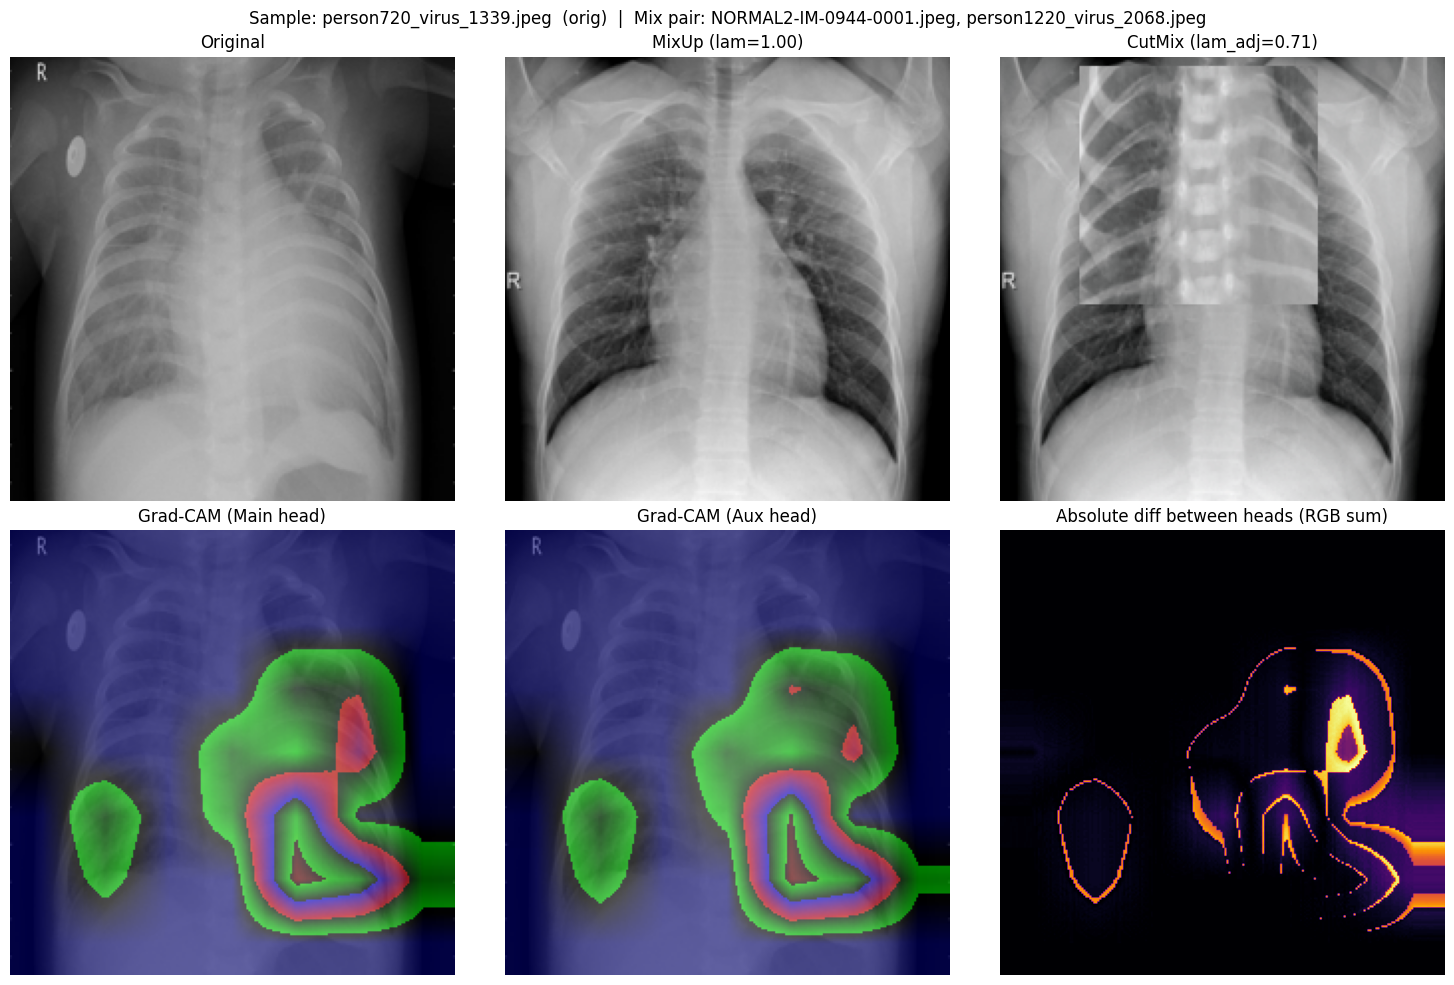

In [9]:
# Visualize original / MixUp / CutMix + Grad-CAM for main and aux heads
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn.functional as F

# ---------- Helper utilities ----------
def denormalize_tensor(tensor):
    """Denormalize a single image tensor (C,H,W) in ImageNet normalization to uint8 array."""
    mean = np.array([0.485, 0.456, 0.406])[:, None, None]
    std  = np.array([0.229, 0.224, 0.225])[:, None, None]
    img = tensor.cpu().numpy()
    img = (img * std + mean)  # channel-first
    img = np.clip(img * 255.0, 0, 255).astype(np.uint8)
    img = np.transpose(img, (1,2,0))  # HWC
    return img

def show_img(ax, arr, title=None):
    ax.imshow(arr)
    ax.axis('off')
    if title:
        ax.set_title(title)

# MixUp / CutMix creation using the same functions used in training
def make_mixup_image(p1, p2, alpha=0.4):
    # p1, p2: PIL Images (RGB), will be transformed by val_transform then mixed
    t1 = val_transform(p1).unsqueeze(0)  # 1x3xHxW
    t2 = val_transform(p2).unsqueeze(0)
    lam = np.random.beta(alpha, alpha)
    mixed = lam * t1 + (1 - lam) * t2
    return mixed.squeeze(0), lam, t1.squeeze(0), t2.squeeze(0)

def make_cutmix_image(p1, p2, alpha=1.0):
    t1 = val_transform(p1).unsqueeze(0)
    t2 = val_transform(p2).unsqueeze(0)
    lam = np.random.beta(alpha, alpha)
    B, C, H, W = t1.shape
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)
    cx = np.random.randint(W)
    cy = np.random.randint(H)
    x1 = np.clip(cx - cut_w // 2, 0, W)
    y1 = np.clip(cy - cut_h // 2, 0, H)
    x2 = np.clip(cx + cut_w // 2, 0, W)
    y2 = np.clip(cy + cut_h // 2, 0, H)
    out = t1.clone()
    out[:, :, y1:y2, x1:x2] = t2[:, :, y1:y2, x1:x2]
    lam_adj = 1 - ((x2 - x1) * (y2 - y1) / (W * H + 1e-8))
    return out.squeeze(0), lam_adj, t1.squeeze(0), t2.squeeze(0)

# ---------- Grad-CAM (hook-based) ----------
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        # forward hook
        def forward_hook(module, inp, out):
            # out shape: B x C x H x W
            self.activations = out.detach()
        # backward hook
        def backward_hook(module, grad_in, grad_out):
            # grad_out is tuple (grad,)
            self.gradients = grad_out[0].detach()
        # register
        self.fh = target_layer.register_forward_hook(forward_hook)
        self.bh = target_layer.register_backward_hook(backward_hook)

    def __call__(self, input_tensor, head='main', class_idx=None):
        """
        input_tensor: 1xC x H x W
        head: 'main' or 'aux' (names from model forward)
        class_idx: if None uses predicted class index
        returns heatmap (H x W) normalized 0-1
        """
        self.model.zero_grad()
        self.activations = None
        self.gradients = None

        input_tensor = input_tensor.to(next(self.model.parameters()).device)
        out_main, out_aux = self.model(input_tensor)
        logits = out_main if head == 'main' else out_aux
        probs = F.softmax(logits, dim=1)
        if class_idx is None:
            class_idx = int(probs.argmax(dim=1).item())
        score = logits[0, class_idx]
        score.backward(retain_graph=True)

        if self.activations is None or self.gradients is None:
            raise RuntimeError("GradCAM hooks didn't capture activations/gradients. Check target layer.")

        # global-average-pool gradients to get weights
        grads = self.gradients[0]         # C x H x W
        acts  = self.activations[0]       # C x H x W
        weights = grads.mean(dim=(1,2))   # C
        # weighted combination
        cam = (weights[:, None, None] * acts).sum(dim=0).cpu().numpy()  # H x W
        # relu
        cam = np.maximum(cam, 0)
        # normalize
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)
        # upsample to IMG_SIZE (activations may be smaller)
        cam = np.uint8(255 * cam)
        cam = Image.fromarray(cam).resize((IMG_SIZE, IMG_SIZE), resample=Image.BILINEAR)
        cam = np.array(cam).astype(np.float32)/255.0
        return cam

    def close(self):
        self.fh.remove()
        self.bh.remove()

# ---------- Find last Conv2d in backbone automatically ----------
def find_last_conv(module):
    last_conv = None
    for name, m in module.named_modules():
        if isinstance(m, torch.nn.Conv2d):
            last_conv = m
            last_name = name
    if last_conv is None:
        raise RuntimeError("No Conv2d found in module")
    return last_conv, last_name

# ---------- Pick a sample image (original) ----------
# choose from test_files if available, else train_files
sample_pool = test_files if len(test_files)>0 else train_files
if len(sample_pool) == 0:
    raise RuntimeError("No image files available in sample pool.")
p0 = random.choice(sample_pool)
img0 = Image.open(p0).convert("RGB").resize((IMG_SIZE, IMG_SIZE))
# transform for model input
inp0 = val_transform(img0).unsqueeze(0).to(DEVICE)  # 1xC x H x W

# ---------- Create MixUp and CutMix examples (from two random images) ----------
p1, p2 = random.sample(sample_pool, 2)
img1 = Image.open(p1).convert("RGB")
img2 = Image.open(p2).convert("RGB")
mixup_img_tensor, lam_mix, _, _ = make_mixup_image(img1, img2, alpha=MIXUP_ALPHA)
cutmix_img_tensor, lam_cut, _, _ = make_cutmix_image(img1, img2, alpha=CUTMIX_ALPHA)

# convert these tensors back to displayable images
mixup_disp = denormalize_tensor(mixup_img_tensor)
cutmix_disp = denormalize_tensor(cutmix_img_tensor)

orig_disp = np.array(img0.resize((IMG_SIZE, IMG_SIZE)))

# ---------- GradCAM on original image for both heads ----------
# find last conv in the backbone
last_conv, last_conv_name = find_last_conv(model.backbone)
gc = GradCAM(model, last_conv)

try:
    cam_main = gc(inp0, head='main', class_idx=None)  # HxW normalized
    cam_aux  = gc(inp0, head='aux',  class_idx=None)
except Exception as e:
    gc.close()
    raise

gc.close()

# overlay heatmap on original image
def overlay_heatmap_on_image(img_arr, heatmap, alpha=0.4):
    heatmap_rgb = plt.cm.jet(heatmap)[:,:,:3]  # H W 3
    heatmap_rgb = (heatmap_rgb * 255).astype(np.uint8)
    # ensure img_arr is uint8 HWC
    base = np.array(Image.fromarray(img_arr).resize((IMG_SIZE, IMG_SIZE))).astype(np.uint8)
    overlay = (heatmap_rgb * 255 * alpha + base * (1-alpha)).astype(np.uint8)
    return overlay

overlay_main = overlay_heatmap_on_image(orig_disp, cam_main, alpha=0.5)
overlay_aux  = overlay_heatmap_on_image(orig_disp, cam_aux, alpha=0.5)

# ---------- Display everything ----------
fig, axes = plt.subplots(2,3, figsize=(15,10))
show_img(axes[0,0], orig_disp, "Original")
show_img(axes[0,1], mixup_disp, f"MixUp (lam={lam_mix:.2f})")
show_img(axes[0,2], cutmix_disp, f"CutMix (lam_adj={lam_cut:.2f})")

show_img(axes[1,0], overlay_main, "Grad-CAM (Main head)")
show_img(axes[1,1], overlay_aux,  "Grad-CAM (Aux head)")
# difference map (abs) to highlight differences
diff = np.abs(overlay_main.astype(int) - overlay_aux.astype(int)).sum(axis=2)
# scale diff to 0-255 for display
dnorm = (diff - diff.min()) / (diff.max() - diff.min() + 1e-8)
axes[1,2].imshow(dnorm, cmap='inferno')
axes[1,2].axis('off')
axes[1,2].set_title("Absolute diff between heads (RGB sum)")

plt.suptitle(f"Sample: {Path(p0).name}  (orig)  |  Mix pair: {Path(p1).name}, {Path(p2).name}")
plt.tight_layout()
plt.show()


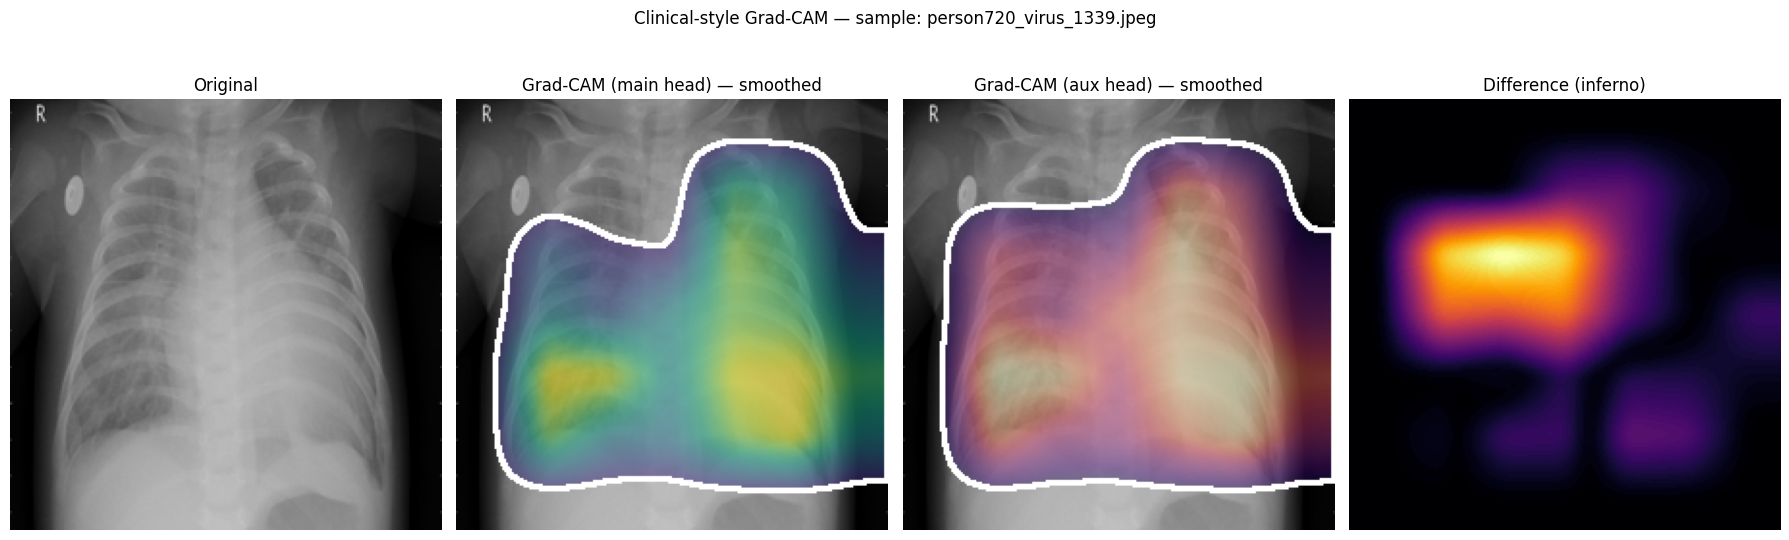

In [10]:
# Clinical-style Grad-CAM visualization (smoother, cleaner)
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter, ImageOps
import torch
import torch.nn.functional as F
import warnings

# ---------- helpers: smoothing (cv2 / scipy / PIL fallback) ----------
def smooth_heatmap(cam, sigma=3):
    """
    cam: numpy array HxW (0..1)
    returns smoothed cam (0..1)
    """
    try:
        import cv2
        # cv2 expects float32
        camf = (cam * 255).astype(np.uint8)
        camf = cv2.GaussianBlur(camf, (0,0), sigmaX=sigma, sigmaY=sigma)
        camf = camf.astype(np.float32) / 255.0
        return camf
    except Exception:
        try:
            from scipy.ndimage import gaussian_filter
            camf = gaussian_filter(cam, sigma=sigma)
            camf = (camf - camf.min()) / (camf.max() - camf.min() + 1e-8)
            return camf
        except Exception:
            # PIL fallback
            pil = Image.fromarray(np.uint8(cam*255))
            pil = pil.filter(ImageFilter.GaussianBlur(radius=sigma))
            arr = np.array(pil).astype(np.float32) / 255.0
            arr = (arr - arr.min()) / (arr.max() - arr.min() + 1e-8)
            return arr

# ---------- overlay function ----------
def overlay_on_image(img_arr, heatmap, colormap='inferno', alpha=0.45, threshold=0.15, contour=False):
    """
    img_arr: uint8 HxWx3 (0..255)
    heatmap: HxW float (0..1)
    Returns overlay uint8 HxWx3
    """
    # smooth
    heatmap_s = smooth_heatmap(heatmap, sigma=4)

    # threshold small values to reduce noise
    heatmap_s[heatmap_s < threshold] = 0.0

    # normalize again
    if heatmap_s.max() > 0:
        heatmap_s = heatmap_s / (heatmap_s.max() + 1e-8)
    else:
        heatmap_s = heatmap_s

    # colormap mapping
    cmap = plt.get_cmap(colormap)
    heatmap_rgb = cmap(heatmap_s)[:,:,:3]  # H W 3 float0..1

    # convert to uint8
    heatmap_rgb = (heatmap_rgb * 255).astype(np.uint8)
    img_uint8 = np.array(Image.fromarray(img_arr.astype(np.uint8)).convert("RGB"))

    # alpha blend only where heatmap > 0
    mask = (heatmap_s > 0).astype(np.float32)[:,:,None]
    overlay = (heatmap_rgb * alpha * mask + img_uint8 * (1.0 - alpha * mask)).astype(np.uint8)

    # optional contour: find boundary of mask and draw white thin contour
    if contour:
        try:
            import cv2
            # mask for contour
            m = (heatmap_s > 0).astype(np.uint8) * 255
            contours, _ = cv2.findContours(m, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            overlay = overlay.copy()
            cv2.drawContours(overlay, contours, -1, (255,255,255), thickness=2)
        except Exception:
            # simple PIL-based contour as fallback: dilate mask and subtract
            pilmask = Image.fromarray(np.uint8(heatmap_s*255)).convert("L")
            pil_dil = pilmask.filter(ImageFilter.MaxFilter(7))
            edge = np.array(pil_dil).astype(int) - np.array(pilmask).astype(int)
            edge = (edge > 0).astype(np.uint8)
            # paint edge white
            overlay[edge==1] = [255,255,255]

    return overlay

# ---------- create Grad-CAM (use your GradCAM or the previous one) ----------
# we will re-use the GradCAM class from earlier. If it's not loaded, raise an informative error.
try:
    GradCAM  # noqa
except NameError:
    raise RuntimeError("GradCAM class/object not found in namespace. Define the GradCAM hook class first (from previous cell).")

# ---------- choose a sample image (same as earlier) ----------
# use inp0 (1xC x H x W) and orig_disp (H x W x 3) from your previous cell.
# If you don't have them, create them similarly:
# p0 = random.choice(test_files); img0 = Image.open(p0).convert('RGB').resize((IMG_SIZE,IMG_SIZE))
# inp0 = val_transform(img0).unsqueeze(0).to(DEVICE); orig_disp = np.array(img0)

try:
    inp0
    orig_disp
except Exception:
    # recreate if missing
    sample_pool = test_files if len(test_files) > 0 else train_files
    p0 = random.choice(sample_pool)
    img0 = Image.open(p0).convert("RGB").resize((IMG_SIZE, IMG_SIZE))
    inp0 = val_transform(img0).unsqueeze(0).to(DEVICE)
    orig_disp = np.array(img0)

# find last conv in model.backbone (same routine as before)
def find_last_conv(module):
    last_conv = None
    for name, m in module.named_modules():
        if isinstance(m, torch.nn.Conv2d):
            last_conv = m
            last_name = name
    if last_conv is None:
        raise RuntimeError("No Conv2d found in module")
    return last_conv, last_name

last_conv, last_conv_name = find_last_conv(model.backbone)
gc = GradCAM(model, last_conv)

# get cams for both heads (main and aux), average multiple passes for stability (smoothgrad-like)
def get_smooth_cam(gc, inp_tensor, head='main', repeats=8, noise_sigma=0.02):
    cams = []
    for _ in range(repeats):
        if noise_sigma > 0:
            noise = torch.randn_like(inp_tensor) * noise_sigma
            inp_noisy = (inp_tensor + noise).clamp(0,1)
        else:
            inp_noisy = inp_tensor
        cam = gc(inp_noisy, head=head, class_idx=None)  # returns 0..1 HxW
        cams.append(cam)
    avg = np.mean(np.stack(cams, axis=0), axis=0)
    # normalize
    if avg.max() > 0:
        avg = (avg - avg.min()) / (avg.max() - avg.min() + 1e-8)
    return avg

cam_main = get_smooth_cam(gc, inp0, head='main', repeats=10, noise_sigma=0.02)
cam_aux  = get_smooth_cam(gc, inp0, head='aux',  repeats=10, noise_sigma=0.02)
gc.close()

# ---------- create overlays ----------
overlay_main = overlay_on_image(orig_disp, cam_main, colormap='viridis', alpha=0.55, threshold=0.12, contour=True)
overlay_aux  = overlay_on_image(orig_disp, cam_aux,  colormap='magma',  alpha=0.45, threshold=0.12, contour=True)

# difference heatmap: smooth difference and use inferno
diff = np.abs(cam_main - cam_aux)
diff = smooth_heatmap(diff, sigma=4)
if diff.max() > 0:
    diff = (diff - diff.min()) / (diff.max() - diff.min() + 1e-8)
diff_rgb = plt.get_cmap("inferno")(diff)[:,:,:3]
diff_rgb = (diff_rgb * 255).astype(np.uint8)

# ---------- display final clinical panels ----------
fig, axes = plt.subplots(1,4, figsize=(18,6))
axes[0].imshow(orig_disp); axes[0].axis('off'); axes[0].set_title("Original")
axes[1].imshow(overlay_main); axes[1].axis('off'); axes[1].set_title("Grad-CAM (main head) — smoothed")
axes[2].imshow(overlay_aux);  axes[2].axis('off'); axes[2].set_title("Grad-CAM (aux head) — smoothed")
axes[3].imshow(diff_rgb);     axes[3].axis('off'); axes[3].set_title("Difference (inferno)")

plt.suptitle(f"Clinical-style Grad-CAM — sample: {Path(p0).name}")
plt.tight_layout()
plt.show()


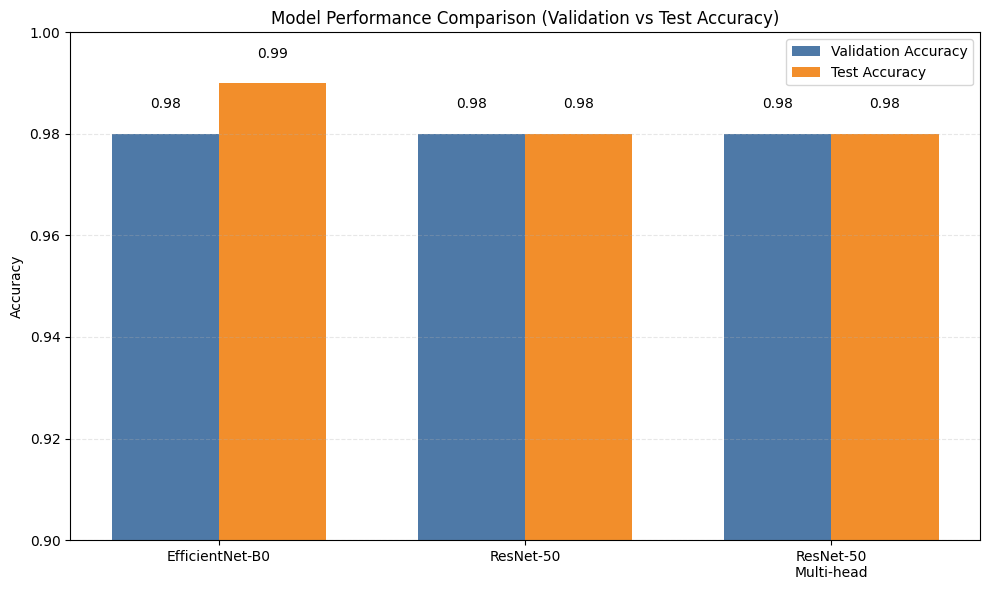

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------
# MODEL PERFORMANCE (from your results)
# -------------------------------

models = ["EfficientNet-B0", "ResNet-50", "ResNet-50\nMulti-head"]

val_acc = [0.98, 0.98, 0.98]   # Validation accuracy
test_acc = [0.99, 0.98, 0.98]  # Test accuracy

x = np.arange(len(models))
width = 0.35

# -------------------------------
# Plot
# -------------------------------
plt.figure(figsize=(10,6))
plt.bar(x - width/2, val_acc, width, label='Validation Accuracy', color='#4e79a7')
plt.bar(x + width/2, test_acc, width, label='Test Accuracy', color='#f28e2b')

# Labels & Title
plt.ylabel("Accuracy")
plt.ylim(0.9, 1.0)
plt.title("Model Performance Comparison (Validation vs Test Accuracy)")

# X-axis labels
plt.xticks(x, models)

# Accuracy numbers on bars
for i, v in enumerate(val_acc):
    plt.text(i - width/2, v + 0.005, f"{v:.2f}", ha='center', fontsize=10)

for i, v in enumerate(test_acc):
    plt.text(i + width/2, v + 0.005, f"{v:.2f}", ha='center', fontsize=10)

plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


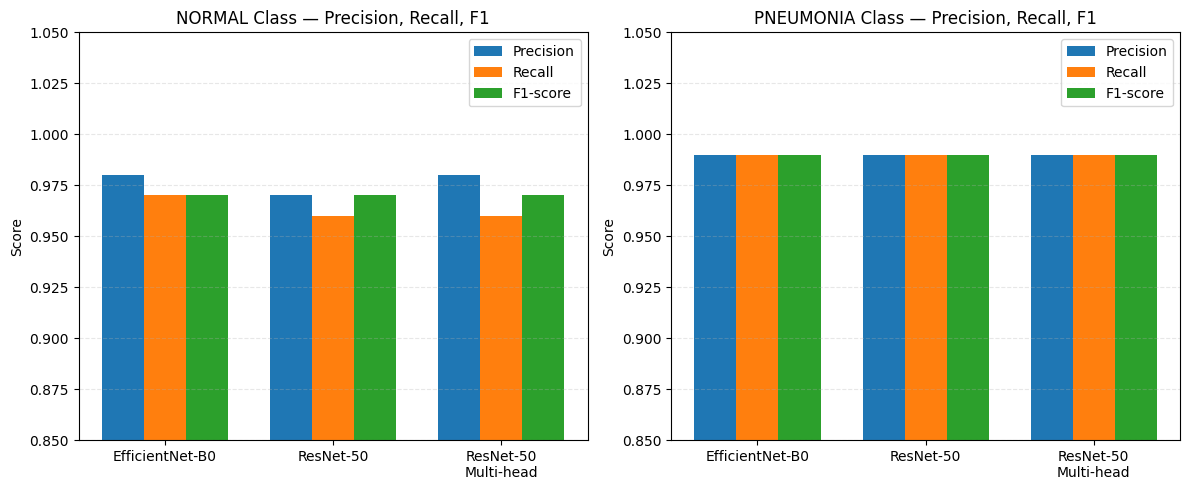

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# ---------------------------
# YOUR TEST RESULTS
# ---------------------------

models = ["EfficientNet-B0", "ResNet-50", "ResNet-50\nMulti-head"]

# Class: NORMAL metrics
precision_normal = [0.98, 0.97, 0.98]
recall_normal    = [0.97, 0.96, 0.96]
f1_normal        = [0.97, 0.97, 0.97]

# Class: PNEUMONIA metrics
precision_pneu = [0.99, 0.99, 0.99]
recall_pneu    = [0.99, 0.99, 0.99]
f1_pneu        = [0.99, 0.99, 0.99]

x = np.arange(len(models))
width = 0.25

# ---------------------------
# PLOT NORMAL class
# ---------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.bar(x - width, precision_normal, width, label="Precision")
plt.bar(x, recall_normal, width, label="Recall")
plt.bar(x + width, f1_normal, width, label="F1-score")

plt.title("NORMAL Class — Precision, Recall, F1")
plt.xticks(x, models)
plt.ylim(0.85, 1.05)
plt.ylabel("Score")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.3)

# ---------------------------
# PLOT PNEUMONIA class
# ---------------------------
plt.subplot(1,2,2)
plt.bar(x - width, precision_pneu, width, label="Precision")
plt.bar(x, recall_pneu, width, label="Recall")
plt.bar(x + width, f1_pneu, width, label="F1-score")

plt.title("PNEUMONIA Class — Precision, Recall, F1")
plt.xticks(x, models)
plt.ylim(0.85, 1.05)
plt.ylabel("Score")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()
